In [2]:
pip install lang2vec

  Using cached lang2vec-1.1.2-py3-none-any.whl.metadata (9.0 kB)
Using cached lang2vec-1.1.2-py3-none-any.whl (10.2 MB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import lang2vec.lang2vec as l2v
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import KFold, GridSearchCV
import matplotlib.pyplot as plt
import re

/opt/micromamba/lib/python3.11/site-packages/lang2vec/lang2vec.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [4]:
avail_lang = l2v.available_languages()

#The Greenberg rules that will be later used as a reference
greenberg_rules = {
    "3": "Languages with dominant VSO order are always prepositional.",
    "4": "With overwhelmingly more than chance frequency, languages with normal SOV order are postpositional.",
    "5": "If a language has dominant SOV order and the genitive follows the governing noun, then the adjective likewise follows the noun.",
    "6": "All languages with dominant VSO order have the adjective after the noun.",
    "16": "If a language has dominant order VSO in declarative sentences, it always puts prepositions before the noun.",
    "17": "With overwhelmingly more than chance frequency, languages with dominant order SOV are postpositional.",
    "18": "When the descriptive adjective precedes the noun, the demonstrative and the numeral likewise precede.",
    "19": "When the descriptive adjective follows the noun, the demonstrative and the numeral likewise follow.",
    "20": "When any or all of the modifiers precede the noun, the genitive almost always precedes.",
    "21": "When any or all of the modifiers follow the noun, the genitive almost always follows.",
    "22": "If in a language the relative clause precedes the noun, the language is postpositional; if it follows, the language is prepositional.",
    "23": "If in a language the verb precedes the object, the adjective likewise precedes the noun.",
    "24": "If in a language the verb follows the object, the adjective likewise follows the noun.",
    "25": "If a language has dominant order VSO, it always has prepositions.",
    "26": "If a language has dominant order SOV, it generally has postpositions.",
    "41": "If in a language the verb follows both the nominal subject and nominal object as the dominant order, the language almost always has a case system."
}

avail_lang_list = []
for lang in avail_lang:
    avail_lang_list.append(str(lang))

# iso_code -> feature_vector
features_dict = l2v.get_features(avail_lang_list, "syntax_wals", header=True)

# extract feature names
feature_names = features_dict["CODE"]

# build a matrix for all languages
# missing values are encoded as the string '--'
rows = []
valid_langs = []

for lang in avail_lang_list:
    if lang not in features_dict:
        print(f"[warning] language {lang} not available, skipping.")
        continue
    rows.append(features_dict[lang])
    valid_langs.append(lang)

# each row is a language, each column is a wals feature
all_syntax_features_df = pd.DataFrame(rows, index=valid_langs, columns=feature_names)

# replace the missing marker '--' with np.nan so pandas can handle it
all_syntax_features_df = all_syntax_features_df.replace("--", np.nan)

print("shape:", all_syntax_features_df.shape)
display(all_syntax_features_df.tail())

shape: (4005, 103)


/tmp/ipykernel_215/1181599309.py:49: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_syntax_features_df = all_syntax_features_df.replace("--", np.nan)


,S_SVO,S_SOV,S_VSO,S_VOS,S_OVS,S_OSV,S_SUBJECT_BEFORE_VERB,S_SUBJECT_AFTER_VERB,S_OBJECT_AFTER_VERB,S_OBJECT_BEFORE_VERB,...,S_XVO,S_XOV,S_OXV,S_OVX,S_OBLIQUE_AFTER_VERB,S_OBLIQUE_AFTER_OBJECT,S_OBLIQUE_BEFORE_VERB,S_OBLIQUE_BEFORE_OBJECT,S_ARTICLE_WORD_BEFORE_NOUN,S_ARTICLE_WORD_AFTER_NOUN
quh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
igb,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
kvj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
les,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ddi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
def select_cols(df, keywords):
    return [c for c in df.columns if any(k in c for k in keywords)]

cols_49A = select_cols(all_syntax_features_df, ["CASE", "CASES"]) # 49A number of cases
cols_50A = select_cols(all_syntax_features_df, ["ASYMMETRIC"]) # 50A asymmetrical case marking
cols_81A = select_cols(all_syntax_features_df, ["SVO", "SOV", "VSO", "VOS", "OVS", "OSV"]) # 81A basic order
cols_85A = select_cols(all_syntax_features_df, ["ADPOSITION", "ADP"]) # 85A adposition + np
cols_86A = select_cols(all_syntax_features_df, ["POSSESSOR"]) # 86A genitive + noun  CHANGED FROM GENETIVE
cols_87A = select_cols(all_syntax_features_df, ["ADJECTIVE"]) # 87A adjective + noun
cols_88A = select_cols(all_syntax_features_df, ["DEMONSTRATIVE"]) # 88A demonstrative + noun
cols_89A = select_cols(all_syntax_features_df, ["NUMERAL"]) # 89A numeral + noun
cols_90A = select_cols(all_syntax_features_df, ["RELATIVE"]) # 90A relative clause + noun

# flatten everything into one list of interesting columns
interesting_cols = (
    cols_49A + cols_50A + cols_81A +
    cols_85A + cols_86A + cols_87A +
    cols_88A + cols_89A + cols_90A
)

# keep only these columns in a new dataframe
focus_syntax_features_df = all_syntax_features_df[interesting_cols].copy()

print("shape (focused on 49A, 50A, 81A, 85A–90A):", focus_syntax_features_df.shape)
non_na_features = focus_syntax_features_df[focus_syntax_features_df.notna().any(axis=1)] # Removing the rows where all the value for all attributes is NaN
display(non_na_features.tail())

shape (focused on 49A, 50A, 81A, 85A–90A): (4005, 30)


,S_CASE_PREFIX,S_CASE_SUFFIX,S_CASE_PROCLITIC,S_CASE_ENCLITIC,S_CASE_MARK,S_SVO,S_SOV,S_VSO,S_VOS,S_OVS,...,S_ANY_AGREEMENT_ON_ADJECTIVES,S_DEMONSTRATIVE_WORD_BEFORE_NOUN,S_DEMONSTRATIVE_WORD_AFTER_NOUN,S_DEMONSTRATIVE_PREFIX,S_DEMONSTRATIVE_SUFFIX,S_NUMERAL_BEFORE_NOUN,S_NUMERAL_AFTER_NOUN,S_RELATIVE_BEFORE_NOUN,S_RELATIVE_AFTER_NOUN,S_RELATIVE_AROUND_NOUN
rou,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,NaN,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
sad,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
ote,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,...,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
igb,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
les,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN


# Rule Based classifier

In [6]:
def rule_based (lang_data):
    '''
    Classification different attributes based on the rules of Greenberg
    '''
    
    attributes = {}

    attributes["RULE_BASED_PRED"] = 1
    
    if lang_data.S_VSO == 1:
        attributes["S_ADPOSITION_BEFORE_NOUN"] = 1 # RULE 3, RULE 25
        attributes["S_ADJECTIVE_AFTER_NOUN"] = 1 # RULE 6

    if lang_data.S_SOV == 1:
        attributes["S_ADPOSITION_AFTER_NOUN"] = 1 # RULE 4, RULE 26
        attributes["S_ADPOSITION_AFTER_NOUN"] = 1 # RULE 17
        if lang_data.S_POSSESSOR_AFTER_NOUN == 1: 
            attributes["S_ADJECTIVE_AFTER_NOUN"] = 1 # RULE 5
        
    if lang_data.S_ADJECTIVE_BEFORE_NOUN == 1:
        attributes["S_DEMONSTRATIVE_WORD_BEFORE_NOUN"] = 1 # RULE 18
        attributes["S_NUMERAL_BEFORE_NOUN"] = 1 # RULE 18

    if lang_data.S_ADJECTIVE_AFTER_NOUN == 1:
        attributes["S_DEMONSTRATIVE_WORD_AFTER_NOUN"] = 1 # RULE 19
        attributes["S_NUMERAL_AFTER_NOUN"] = 1 # RULE 19

    if (lang_data.S_ADJECTIVE_BEFORE_NOUN == 1 or lang_data.S_DEMONSTRATIVE_WORD_BEFORE_NOUN == 1 or lang_data.S_NUMERAL_BEFORE_NOUN == 1):
        attributes["S_POSSESSOR_BEFORE_NOUN"] = 1 # RULE 20

    if (lang_data.S_ADJECTIVE_AFTER_NOUN == 1 or lang_data.S_DEMONSTRATIVE_WORD_AFTER_NOUN == 1 or lang_data.S_NUMERAL_AFTER_NOUN == 1):
        attributes["S_POSSESSOR_BEFORE_NOUN"] = 1 # RULE 21

    if lang_data.S_RELATIVE_BEFORE_NOUN == 1:
        attributes["S_ADPOSITION_AFTER_NOUN"] = 1 # RULE 22
    if lang_data.S_RELATIVE_AFTER_NOUN == 1:
        attributes["S_ADPOSITION_BEFORE_NOUN"] = 1 # RULE 22

    if (lang_data.S_SVO == 1 or lang_data.S_VSO == 1 or lang_data.S_VOS == 1):
        attributes["S_ADJECTIVE_BEFORE_NOUN"] = 1 # RULE 23

    if (lang_data.S_SOV == 1 or lang_data.S_OVS == 1 or lang_data.S_OSV == 1):
        attributes["S_ADJECTIVE_AFTER_NOUN"] = 1 # RULE 24

    if (lang_data.S_SOV == 1 or lang_data.S_OSV == 1):
        attributes["HAS_CASE_SYSTEM"] = 1 # RULE 41. NEEDS TO BE EVALUATED DIFFERENTLY

    
    return attributes

    """
    NOT IMPLEMENTED
    RULE 16: If a language has dominant order VSO in declarative sentences, it always puts prepositions before the noun.

    """
    

In [7]:
rule_based_predictions = {}

for lang in non_na_features.index:
    preds = rule_based(non_na_features.loc[lang]) # Predict some attributes for each language
    rule_based_predictions[non_na_features.loc[lang].name] = preds #Create a row in the dictionary with the predictions for that language

rule_based_pred_df = pd.DataFrame.from_dict(rule_based_predictions, orient="index") # Convert the dictionary to a dataframe 

In [8]:
def pred_eval(pred_df, ground_truth_df): 
    '''
    Evaluate the predictions of the rule based classifier with the ground truth
    '''
    # Columns that could have been predicted
    relevant_cols = [
        'S_DEMONSTRATIVE_WORD_AFTER_NOUN', 'S_NUMERAL_AFTER_NOUN', 'S_POSSESSOR_BEFORE_NOUN', 'S_ADPOSITION_BEFORE_NOUN', 
        'S_ADJECTIVE_AFTER_NOUN', 'S_ADJECTIVE_BEFORE_NOUN', 'S_DEMONSTRATIVE_WORD_BEFORE_NOUN', 'S_NUMERAL_BEFORE_NOUN',
        'S_ADPOSITION_AFTER_NOUN', 'HAS_CASE_SYSTEM'
    ] 
    
    ground_truth_df_converted = ground_truth_df.copy()
    ground_truth_df_converted["HAS_CASE_SYSTEM"] = np.where(
            (ground_truth_df_converted["S_CASE_PREFIX"] > 0) | 
            (ground_truth_df_converted["S_CASE_SUFFIX"] > 0) |
            (ground_truth_df_converted["S_CASE_PROCLITIC"] > 0) |
            (ground_truth_df_converted["S_CASE_ENCLITIC"] > 0) |
            (ground_truth_df_converted["S_CASE_MARK"] > 0) 
            , 1, 0) # Since HAS_CASE_SYSTEM isn't a feature in the WALS dataset, we create on based on any of the case features having a value

    ground_truth_df_converted_rel = ground_truth_df_converted[relevant_cols].copy()
    pred_df_rel = pred_df[relevant_cols].copy()

    comparison_df = ground_truth_df_converted_rel.join(pred_df_rel, how='outer', lsuffix='_truth', rsuffix='_pred') # Joining the two datasets for easy comparison

    pred_results = {}
    
    for col in relevant_cols:
        total = len(comparison_df.index)
        # The rows where either there was either no prediciton made or the ground truth is missing are counted as incomparable
        incomparable = len(comparison_df[(pd.isna(comparison_df[col + "_truth"]))| (pd.isna(comparison_df[col + "_pred"]))].index)
        tp = len(comparison_df[(comparison_df[col + "_truth"] == 1) & (comparison_df[col + "_truth"] == comparison_df[col + "_pred"]) & (pd.notna(comparison_df[col + "_truth"])) & (pd.notna(comparison_df[col + "_pred"]))].index)
        fp = len(comparison_df[(comparison_df[col + "_pred"] == 1) & (comparison_df[col + "_truth"] != comparison_df[col + "_pred"]) & (pd.notna(comparison_df[col + "_truth"])) & (pd.notna(comparison_df[col + "_pred"]))].index)
        correct = len(comparison_df[(comparison_df[col + "_truth"] == comparison_df[col + "_pred"]) & (pd.notna(comparison_df[col + "_truth"])) & (pd.notna(comparison_df[col + "_pred"]))].index)
        tn = len(comparison_df[(comparison_df[col + "_truth"] == 0) & (comparison_df[col + "_truth"] == comparison_df[col + "_pred"]) & (pd.notna(comparison_df[col + "_truth"])) & (pd.notna(comparison_df[col + "_pred"]))].index)
        fn = len(comparison_df[(comparison_df[col + "_pred"] == 0) & (comparison_df[col + "_truth"] != comparison_df[col + "_pred"]) & (pd.notna(comparison_df[col + "_truth"])) & (pd.notna(comparison_df[col + "_pred"]))].index)
        incorrect = len(comparison_df[(comparison_df[col + "_truth"] != comparison_df[col + "_pred"]) & (pd.notna(comparison_df[col + "_truth"])) & (pd.notna(comparison_df[col + "_pred"]))].index)

        pred_results[col] = {"total languages": total, "incomparable": incomparable, "correct": correct, "incorrect": incorrect, "tp": tp, "fp": fp, "tn": tn, "fn": fn}

    return pred_results

In [10]:


results_rule_based_comp = pred_eval(rule_based_pred_df, non_na_features)
results_rule_based_comp_df = pd.DataFrame.from_dict(results_rule_based_comp, orient="index")
#Mapping the predictions too which rules they could have steamed from
results_rule_based_comp_df["Rule mapping"] = "NA"
results_rule_based_comp_df["Rule mapping"] = np.where((results_rule_based_comp_df.index == "S_DEMONSTRATIVE_WORD_AFTER_NOUN") | (results_rule_based_comp_df.index == "S_NUMERAL_AFTER_NOUN"), "19", results_rule_based_comp_df["Rule mapping"]) 
results_rule_based_comp_df["Rule mapping"] = np.where(results_rule_based_comp_df.index == "S_POSSESSOR_BEFORE_NOUN", "20, 21", results_rule_based_comp_df["Rule mapping"]) 
results_rule_based_comp_df["Rule mapping"] = np.where(results_rule_based_comp_df.index == "S_ADPOSITION_BEFORE_NOUN", "3, 25, 22", results_rule_based_comp_df["Rule mapping"]) 
results_rule_based_comp_df["Rule mapping"] = np.where(results_rule_based_comp_df.index == "S_ADJECTIVE_AFTER_NOUN", "5, 6, 24", results_rule_based_comp_df["Rule mapping"]) 
results_rule_based_comp_df["Rule mapping"] = np.where(results_rule_based_comp_df.index == "S_ADJECTIVE_BEFORE_NOUN", "23", results_rule_based_comp_df["Rule mapping"])
results_rule_based_comp_df["Rule mapping"] = np.where(results_rule_based_comp_df.index == "S_DEMONSTRATIVE_WORD_BEFORE_NOUN", "18", results_rule_based_comp_df["Rule mapping"]) 
results_rule_based_comp_df["Rule mapping"] = np.where(results_rule_based_comp_df.index == "S_NUMERAL_BEFORE_NOUN", "18", results_rule_based_comp_df["Rule mapping"]) 
results_rule_based_comp_df["Rule mapping"] = np.where(results_rule_based_comp_df.index == "S_ADPOSITION_AFTER_NOUN", "4, 17, 22, 26", results_rule_based_comp_df["Rule mapping"]) 
results_rule_based_comp_df["Rule mapping"] = np.where(results_rule_based_comp_df.index == "HAS_CASE_SYSTEM", "41", results_rule_based_comp_df["Rule mapping"]) 

results_rule_based_comp_df["accuracy"] = round(results_rule_based_comp_df["correct"]/(results_rule_based_comp_df["correct"] + results_rule_based_comp_df["incorrect"]),2)


results_rule_based_comp_df = results_rule_based_comp_df.sort_values(by=["accuracy"], ascending=False)

In [11]:
results_rule_based_comp_df

,total languages,incomparable,correct,incorrect,tp,fp,tn,fn,Rule mapping,accuracy
S_ADPOSITION_AFTER_NOUN,1560,1102,429,29,429,29,0,0,"4, 17, 22, 26",0.94
S_DEMONSTRATIVE_WORD_BEFORE_NOUN,1560,1197,317,46,317,46,0,0,18,0.87
S_NUMERAL_BEFORE_NOUN,1560,1198,305,57,305,57,0,0,18,0.84
S_NUMERAL_AFTER_NOUN,1560,799,563,198,563,198,0,0,19,0.74
S_ADPOSITION_BEFORE_NOUN,1560,1003,411,146,411,146,0,0,"3, 25, 22",0.74
S_DEMONSTRATIVE_WORD_AFTER_NOUN,1560,814,492,254,492,254,0,0,19,0.66
S_ADJECTIVE_AFTER_NOUN,1560,956,391,213,391,213,0,0,"5, 6, 24",0.65
S_POSSESSOR_BEFORE_NOUN,1560,387,725,448,725,448,0,0,"20, 21",0.62
HAS_CASE_SYSTEM,1560,984,325,251,325,251,0,0,41,0.56
S_ADJECTIVE_BEFORE_NOUN,1560,966,146,448,146,448,0,0,23,0.25


## Conclusions

The cell above displays the results of applying a rule based classifier, built upon the original Greenberg Universals for a number of different properties of languages available in the WALS dataset.

The classifier was created by applying the rewriting the rules so that each attribute was predicted by the Greenberg Universals that relates to the attribute. 

From the results we can see that the rules predicting the placement of the adposition had a relativly high accuracy. The worst accuracy could be seen on rules regarding if the language has a case system or not. Important to note here is that "HAS_CASE_SYSTEM" is not a feature that exists in the WALS dataset, it was instead an combined attribute which was set to be true if any of the attributes regarding CASE was true in a language. This generalization could be a reason for the poor predictive performance of the classifier on this attribute.

# Shallow Decision Tree 

In [9]:
def train_deci_tree_with_grid(df, target_attribute, max_depth):
    
    param_grid = {
      'criterion': ["entropy"],
      'min_samples_split': range(2,10,1),
      "max_depth": range(1,max_depth,1)

    }

    if target_attribute == "HAS_CASE_SYSTEM":
        target_name = "CASE"
    else:
        target_name = re.search(r"S_([^_]+)", target_attribute).group(1)
    x = df.loc[:, (df.columns != target_attribute) & ~(df.columns.str.contains(target_name, regex= True, na=False))] # Exclude attributes related to the target 
    y = df[target_attribute]
    
    tree = DecisionTreeClassifier(random_state=1)
    
    cv_strategy = KFold(
    n_splits=5,
    shuffle=True,
    random_state=1
    )
    
    grid_search = GridSearchCV(
      estimator=tree,
      param_grid=param_grid,
      cv=cv_strategy,
      refit="Accuracy",
      verbose=True
    )
    
    grid_search.fit(x,y)
    
    return grid_search.best_estimator_, x

In [10]:
def pred_eval_decision_tree(pred_df, ground_truth_df, col): 
    
    ground_truth_df_converted = ground_truth_df.copy()

    ground_truth_df_converted_rel = ground_truth_df_converted[col].copy()
    pred_df_rel = pred_df[col].copy()

    comparison_df = ground_truth_df_converted_rel.to_frame().join(pred_df_rel.to_frame(), how='outer', lsuffix='_truth', rsuffix='_pred')

    pred_results = {}
    
    total = len(comparison_df.index)
    incomparable = len(comparison_df[(pd.isna(comparison_df[col + "_truth"]))| (pd.isna(comparison_df[col + "_pred"]))].index)
    tp = len(comparison_df[(comparison_df[col + "_truth"] == 1) & (comparison_df[col + "_truth"] == comparison_df[col + "_pred"]) & (pd.notna(comparison_df[col + "_truth"])) & (pd.notna(comparison_df[col + "_pred"]))].index)
    fp = len(comparison_df[(comparison_df[col + "_pred"] == 1) & (comparison_df[col + "_truth"] != comparison_df[col + "_pred"]) & (pd.notna(comparison_df[col + "_truth"])) & (pd.notna(comparison_df[col + "_pred"]))].index)    
    correct = len(comparison_df[(comparison_df[col + "_truth"] == comparison_df[col + "_pred"]) & (pd.notna(comparison_df[col + "_truth"])) & (pd.notna(comparison_df[col + "_pred"]))].index)
    tn = len(comparison_df[(comparison_df[col + "_truth"] == 0) & (comparison_df[col + "_truth"] == comparison_df[col + "_pred"]) & (pd.notna(comparison_df[col + "_truth"])) & (pd.notna(comparison_df[col + "_pred"]))].index)
    fn = len(comparison_df[(comparison_df[col + "_pred"] == 0) & (comparison_df[col + "_truth"] != comparison_df[col + "_pred"]) & (pd.notna(comparison_df[col + "_truth"])) & (pd.notna(comparison_df[col + "_pred"]))].index)    
    incorrect = len(comparison_df[(comparison_df[col + "_truth"] != comparison_df[col + "_pred"]) & (pd.notna(comparison_df[col + "_truth"])) & (pd.notna(comparison_df[col + "_pred"]))].index)

    pred_results[col] = {"total languages": total, "incomparable": incomparable, "correct": correct, "incorrect": incorrect, "tp": tp, "fp": fp, "tn": tn, "fn": fn}

    return pred_results

In [18]:
def train_tree(max_depth):
    relevant_cols = [
        'S_DEMONSTRATIVE_WORD_AFTER_NOUN', 'S_NUMERAL_AFTER_NOUN', 'S_POSSESSOR_BEFORE_NOUN', 'S_ADPOSITION_BEFORE_NOUN', 
        'S_ADJECTIVE_AFTER_NOUN', 'S_ADJECTIVE_BEFORE_NOUN', 'S_DEMONSTRATIVE_WORD_BEFORE_NOUN', 'S_NUMERAL_BEFORE_NOUN',
        'S_ADPOSITION_AFTER_NOUN', 'HAS_CASE_SYSTEM'
    ]
    
    results_decision_tree_comp = []
    models = {}
    x_attributes = {}
    
    for col in relevant_cols:
        if col != "HAS_CASE_SYSTEM":
            non_na_y_features = non_na_features[pd.notna(non_na_features[col])]
        elif col == "HAS_CASE_SYSTEM":
            non_na_y_features = non_na_features.copy()
            non_na_y_features["HAS_CASE_SYSTEM"] = np.where(
            (non_na_y_features["S_CASE_PREFIX"] > 0) | 
            (non_na_y_features["S_CASE_SUFFIX"] > 0) |
            (non_na_y_features["S_CASE_PROCLITIC"] > 0) |
            (non_na_y_features["S_CASE_ENCLITIC"] > 0) |
            (non_na_y_features["S_CASE_MARK"] > 0) 
            , 1, 0) 
            non_na_y_features = non_na_y_features.drop(columns=["S_CASE_PREFIX", "S_CASE_SUFFIX","S_CASE_PROCLITIC","S_CASE_ENCLITIC","S_CASE_MARK"])
            
        models[col], x = train_deci_tree_with_grid(non_na_y_features, col, max_depth)
        x_attributes[col] = x.columns
        
        pred = models[col].predict(x)
    
        decision_tree_pred_df = pd.DataFrame()
        decision_tree_pred_df.index = non_na_y_features.index
        decision_tree_pred_df[col] = pred.tolist()
    
        results_decision_tree_comp.append(pred_eval_decision_tree(decision_tree_pred_df, non_na_y_features, col))

    return results_decision_tree_comp, models, x_attributes


In [19]:
results_decision_tree_comp_shallow, models_shallow, x_attributes_shallow = train_tree(2)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [20]:
results_decision_tree_comp_df_shallow = pd.DataFrame.from_dict(
    {list(d.keys())[0]: list(d.values())[0] for d in results_decision_tree_comp_shallow},
    orient="index"
)
results_decision_tree_comp_df_shallow["accuracy"] = round((results_decision_tree_comp_df_shallow["tp"] + results_decision_tree_comp_df_shallow["tn"])/(results_decision_tree_comp_df_shallow["tp"] + results_decision_tree_comp_df_shallow["fp"] + results_decision_tree_comp_df_shallow["tn"] + results_decision_tree_comp_df_shallow["fn"]),2)
results_decision_tree_comp_df_shallow

,total languages,incomparable,correct,incorrect,tp,fp,tn,fn,accuracy
S_DEMONSTRATIVE_WORD_AFTER_NOUN,1126,0,825,301,511,252,314,49,0.73
S_NUMERAL_AFTER_NOUN,1124,0,854,270,607,222,247,48,0.76
S_POSSESSOR_BEFORE_NOUN,1216,0,917,299,470,16,447,283,0.75
S_ADPOSITION_BEFORE_NOUN,1144,0,985,159,460,57,525,102,0.86
S_ADJECTIVE_AFTER_NOUN,1314,0,952,362,952,362,0,0,0.72
S_ADJECTIVE_BEFORE_NOUN,1314,0,907,407,418,361,489,46,0.69
S_DEMONSTRATIVE_WORD_BEFORE_NOUN,1126,0,852,274,317,46,535,228,0.76
S_NUMERAL_BEFORE_NOUN,1124,0,839,285,305,57,534,228,0.75
S_ADPOSITION_AFTER_NOUN,1144,0,968,176,531,96,437,80,0.85
HAS_CASE_SYSTEM,1560,0,994,566,476,436,518,130,0.64


In [46]:
def plot_rules(results_decision_tree_comp_df, models, x_attributes):
    for key in models:
        print(f"Decision tree for predicting {key}")
        plt.figure(figsize=(18, 10))
        tree.plot_tree(models[key], feature_names=x_attributes[key], class_names=models[key].classes_.astype(str), filled=True)
        print("Results of the rule")
        print(results_decision_tree_comp_df.loc[key])
        print(f"Accuracy of decision tree rule / Accuracy of Greenberg rule based classifier: {results_decision_tree_comp_df.loc[key]['accuracy']} / {results_rule_based_comp_df.loc[key]['accuracy']}")
        print("Related Greenberg rules")
        for value in str({results_rule_based_comp_df.loc[key]["Rule mapping"]}).split(","):
            string1 = value.strip("{}'")
            string2 = greenberg_rules[value.strip("{}'").strip(" ")]
            print(f"Rule {string1}: {string2}")
        plt.show()
        print(export_text(models[key], feature_names=x_attributes[key], show_weights=True))

Decision tree for predicting S_DEMONSTRATIVE_WORD_AFTER_NOUN
Results of the rule
total languages    1126.00
incomparable          0.00
correct             825.00
incorrect           301.00
tp                  511.00
fp                  252.00
tn                  314.00
fn                   49.00
accuracy              0.73
Name: S_DEMONSTRATIVE_WORD_AFTER_NOUN, dtype: float64
Accuracy of decision tree rule / Accuracy of Greenberg rule based classifier: 0.73 / 0.66
Related Greenberg rules
Rule 19: When the descriptive adjective follows the noun, the demonstrative and the numeral likewise follow.


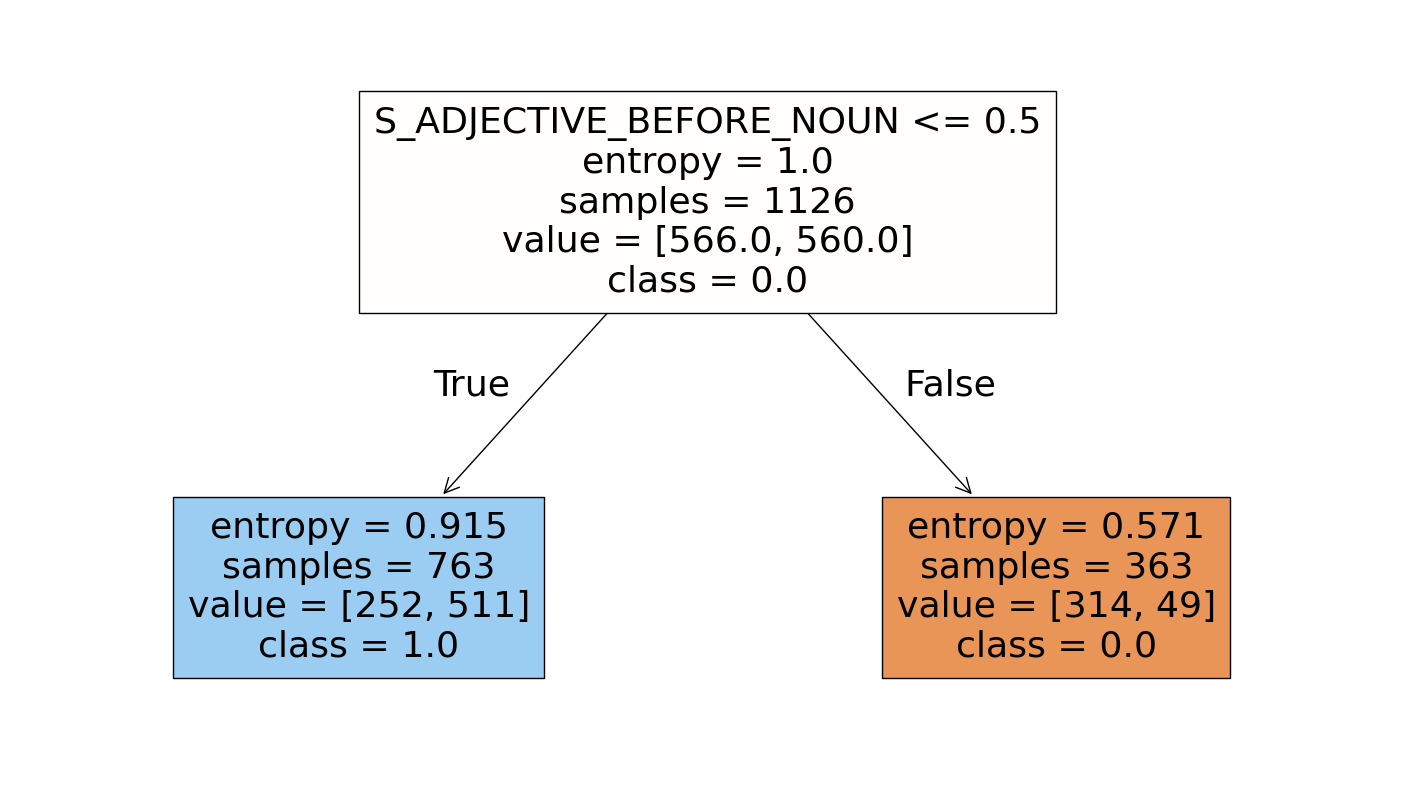

|--- S_ADJECTIVE_BEFORE_NOUN <= 0.50
|   |--- weights: [252.00, 511.00] class: 1.0
|--- S_ADJECTIVE_BEFORE_NOUN >  0.50
|   |--- weights: [314.00, 49.00] class: 0.0

Decision tree for predicting S_NUMERAL_AFTER_NOUN
Results of the rule
total languages    1124.00
incomparable          0.00
correct             854.00
incorrect           270.00
tp                  607.00
fp                  222.00
tn                  247.00
fn                   48.00
accuracy              0.76
Name: S_NUMERAL_AFTER_NOUN, dtype: float64
Accuracy of decision tree rule / Accuracy of Greenberg rule based classifier: 0.76 / 0.74
Related Greenberg rules
Rule 19: When the descriptive adjective follows the noun, the demonstrative and the numeral likewise follow.


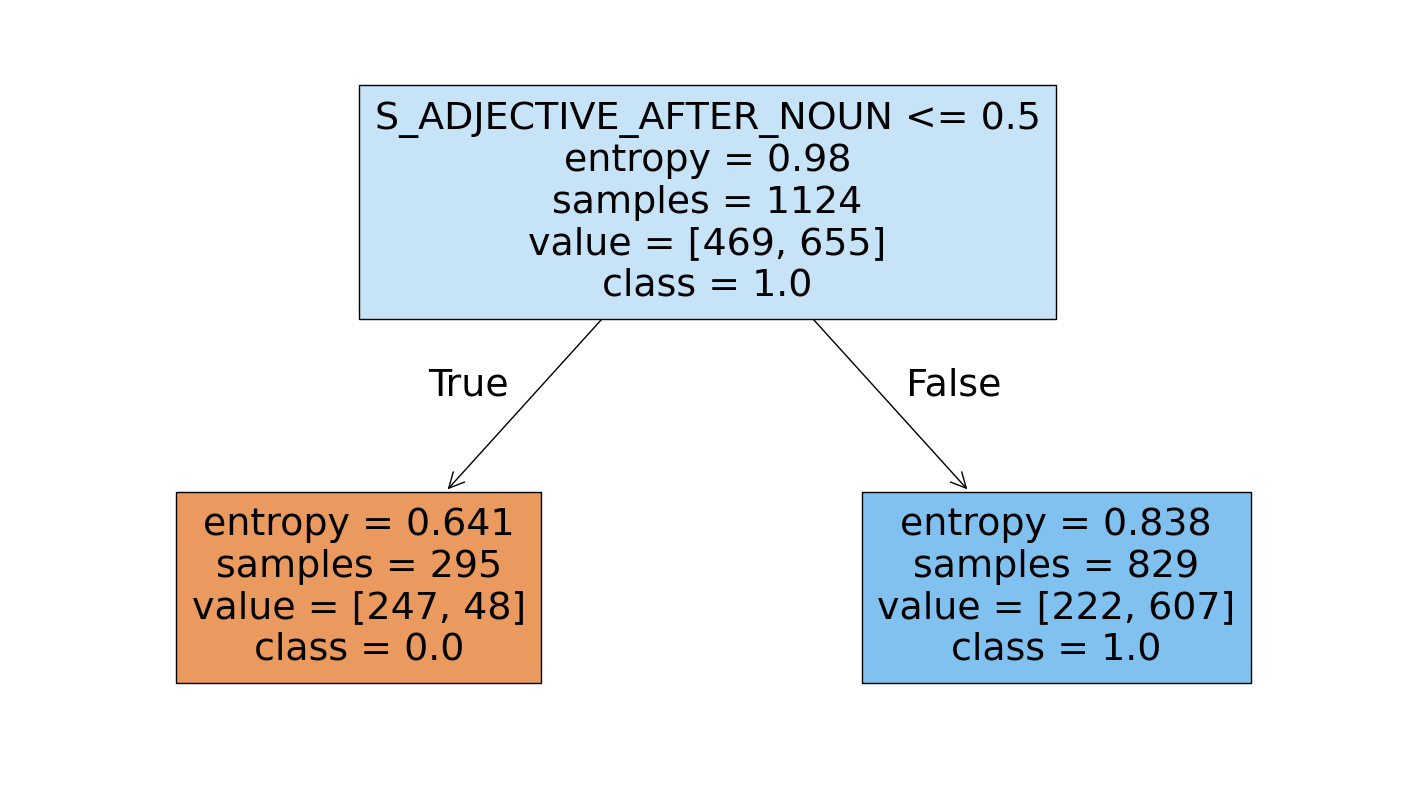

|--- S_ADJECTIVE_AFTER_NOUN <= 0.50
|   |--- weights: [247.00, 48.00] class: 0.0
|--- S_ADJECTIVE_AFTER_NOUN >  0.50
|   |--- weights: [222.00, 607.00] class: 1.0

Decision tree for predicting S_POSSESSOR_BEFORE_NOUN
Results of the rule
total languages    1216.00
incomparable          0.00
correct             917.00
incorrect           299.00
tp                  470.00
fp                   16.00
tn                  447.00
fn                  283.00
accuracy              0.75
Name: S_POSSESSOR_BEFORE_NOUN, dtype: float64
Accuracy of decision tree rule / Accuracy of Greenberg rule based classifier: 0.75 / 0.62
Related Greenberg rules
Rule 20: When any or all of the modifiers precede the noun, the genitive almost always precedes.
Rule  21: When any or all of the modifiers follow the noun, the genitive almost always follows.


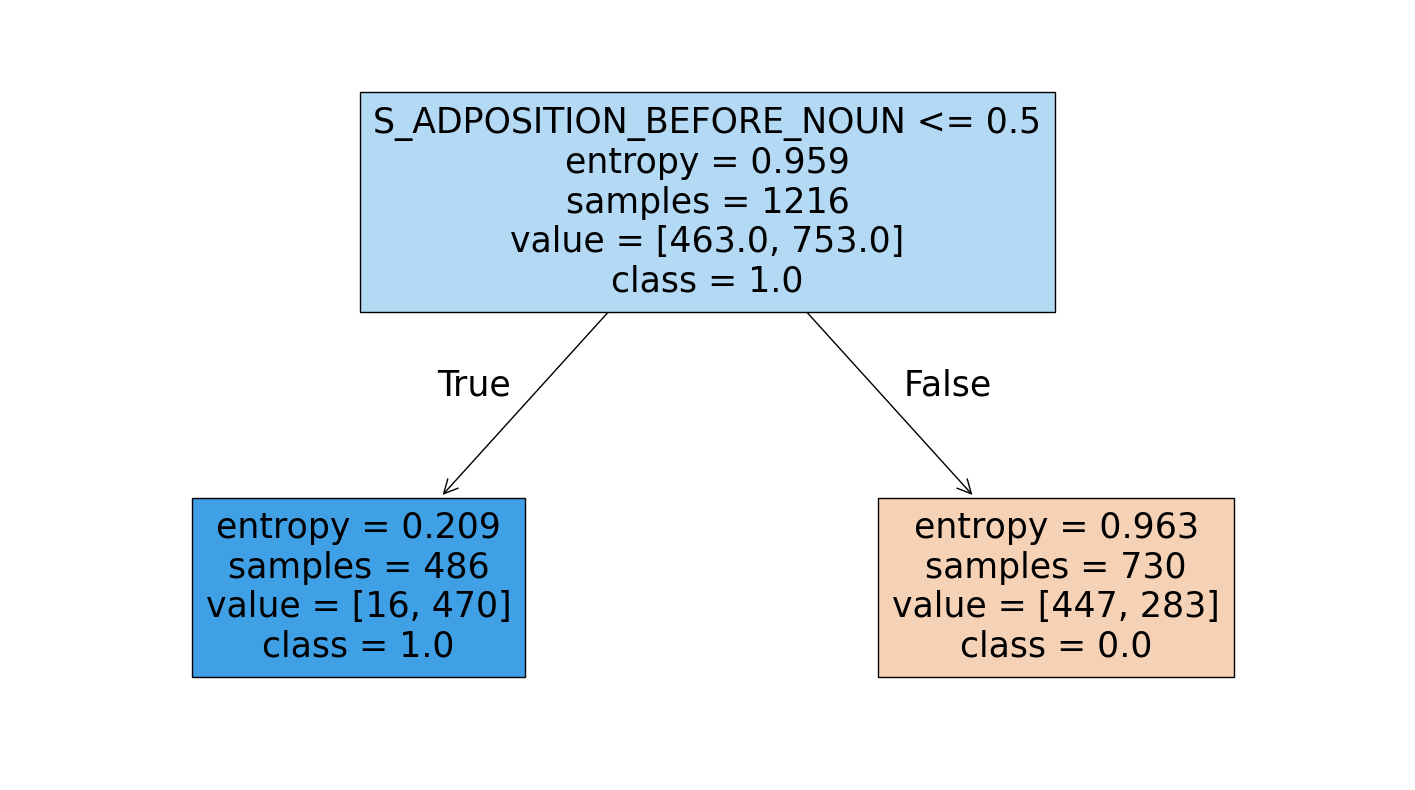

|--- S_ADPOSITION_BEFORE_NOUN <= 0.50
|   |--- weights: [16.00, 470.00] class: 1.0
|--- S_ADPOSITION_BEFORE_NOUN >  0.50
|   |--- weights: [447.00, 283.00] class: 0.0

Decision tree for predicting S_ADPOSITION_BEFORE_NOUN
Results of the rule
total languages    1144.00
incomparable          0.00
correct             985.00
incorrect           159.00
tp                  460.00
fp                   57.00
tn                  525.00
fn                  102.00
accuracy              0.86
Name: S_ADPOSITION_BEFORE_NOUN, dtype: float64
Accuracy of decision tree rule / Accuracy of Greenberg rule based classifier: 0.86 / 0.74
Related Greenberg rules
Rule 3: Languages with dominant VSO order are always prepositional.
Rule  25: If a language has dominant order VSO, it always has prepositions.
Rule  22: If in a language the relative clause precedes the noun, the language is postpositional; if it follows, the language is prepositional.


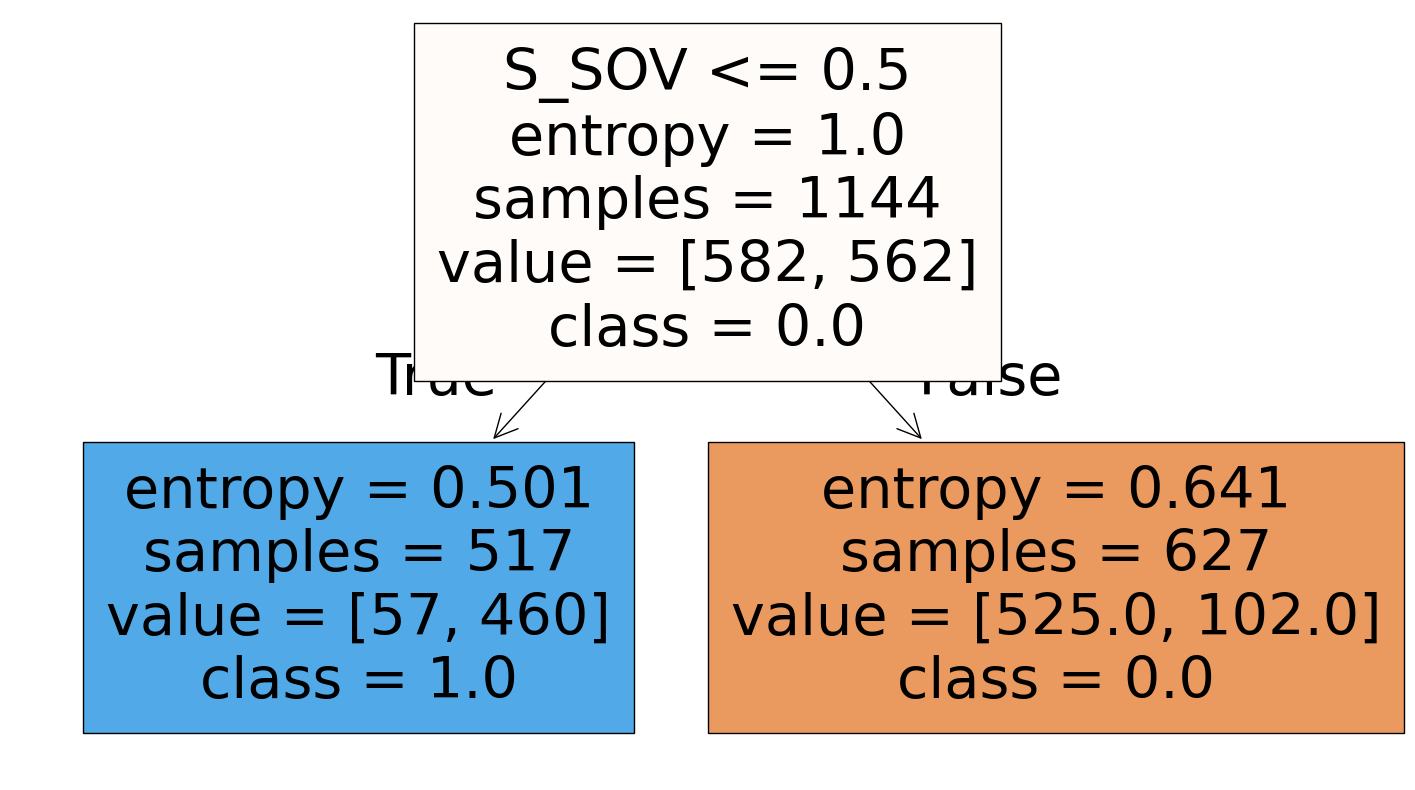

|--- S_SOV <= 0.50
|   |--- weights: [57.00, 460.00] class: 1.0
|--- S_SOV >  0.50
|   |--- weights: [525.00, 102.00] class: 0.0

Decision tree for predicting S_ADJECTIVE_AFTER_NOUN
Results of the rule
total languages    1314.00
incomparable          0.00
correct             952.00
incorrect           362.00
tp                  952.00
fp                  362.00
tn                    0.00
fn                    0.00
accuracy              0.72
Name: S_ADJECTIVE_AFTER_NOUN, dtype: float64
Accuracy of decision tree rule / Accuracy of Greenberg rule based classifier: 0.72 / 0.65
Related Greenberg rules
Rule 5: If a language has dominant SOV order and the genitive follows the governing noun, then the adjective likewise follows the noun.
Rule  6: All languages with dominant VSO order have the adjective after the noun.
Rule  24: If in a language the verb follows the object, the adjective likewise follows the noun.


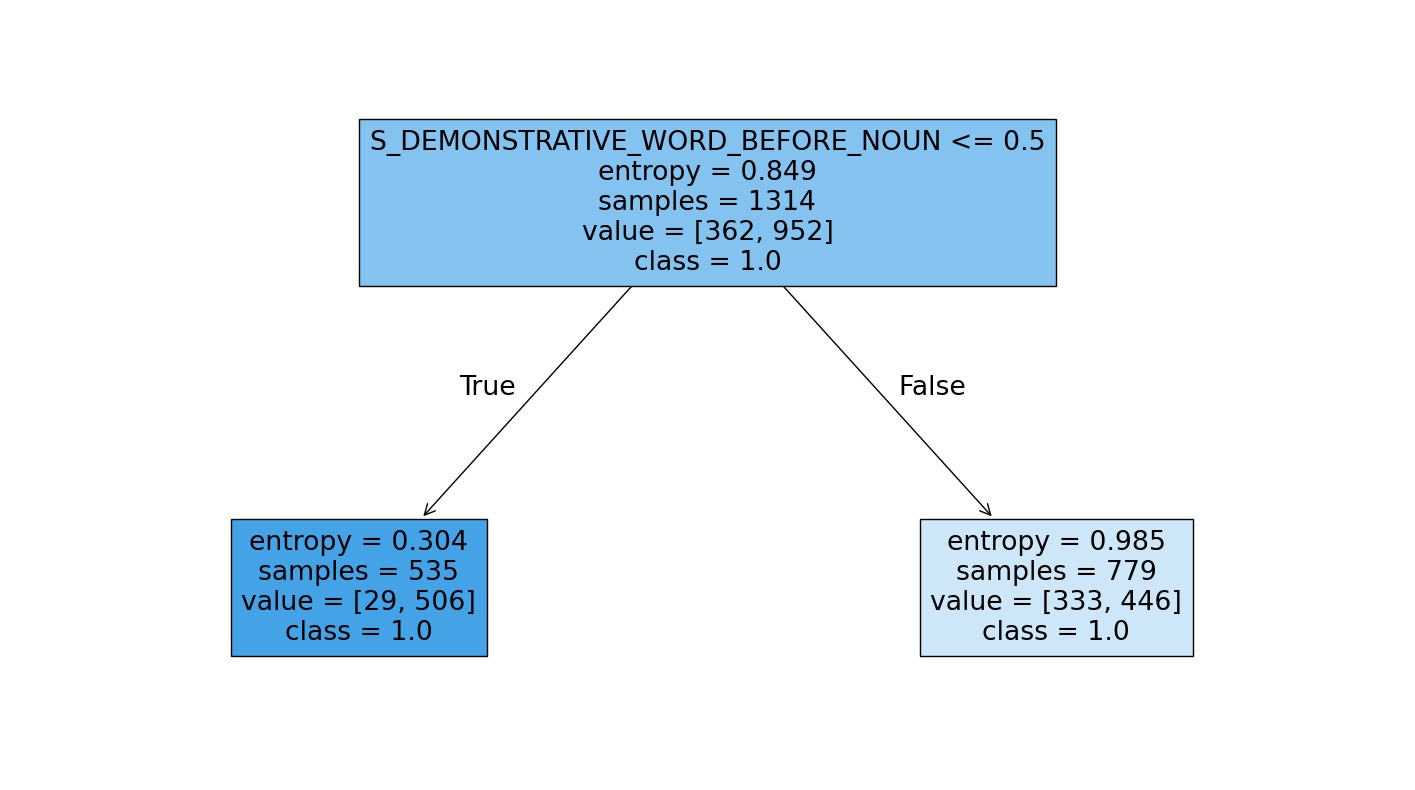

|--- S_DEMONSTRATIVE_WORD_BEFORE_NOUN <= 0.50
|   |--- weights: [29.00, 506.00] class: 1.0
|--- S_DEMONSTRATIVE_WORD_BEFORE_NOUN >  0.50
|   |--- weights: [333.00, 446.00] class: 1.0

Decision tree for predicting S_ADJECTIVE_BEFORE_NOUN
Results of the rule
total languages    1314.00
incomparable          0.00
correct             907.00
incorrect           407.00
tp                  418.00
fp                  361.00
tn                  489.00
fn                   46.00
accuracy              0.69
Name: S_ADJECTIVE_BEFORE_NOUN, dtype: float64
Accuracy of decision tree rule / Accuracy of Greenberg rule based classifier: 0.69 / 0.25
Related Greenberg rules
Rule 23: If in a language the verb precedes the object, the adjective likewise precedes the noun.


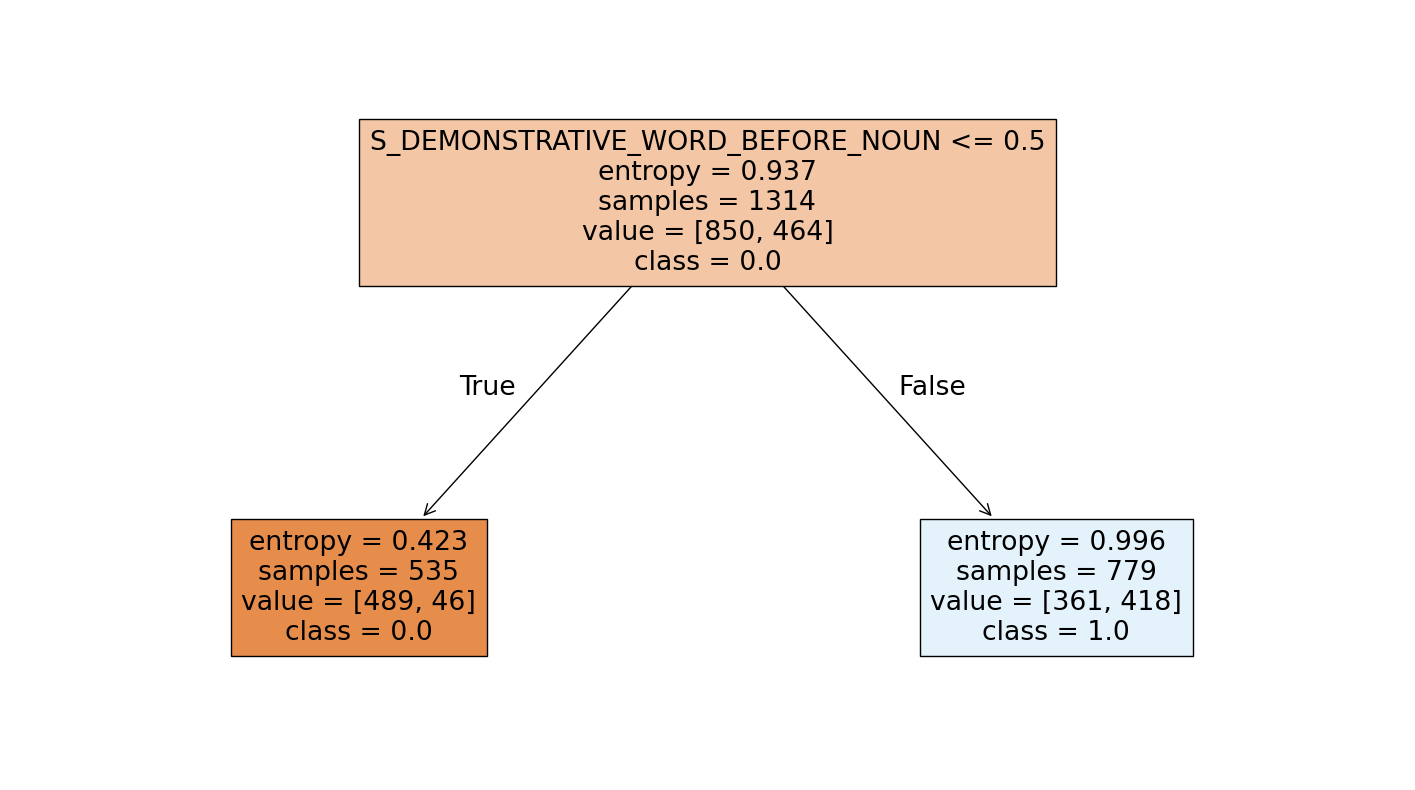

|--- S_DEMONSTRATIVE_WORD_BEFORE_NOUN <= 0.50
|   |--- weights: [489.00, 46.00] class: 0.0
|--- S_DEMONSTRATIVE_WORD_BEFORE_NOUN >  0.50
|   |--- weights: [361.00, 418.00] class: 1.0

Decision tree for predicting S_DEMONSTRATIVE_WORD_BEFORE_NOUN
Results of the rule
total languages    1126.00
incomparable          0.00
correct             852.00
incorrect           274.00
tp                  317.00
fp                   46.00
tn                  535.00
fn                  228.00
accuracy              0.76
Name: S_DEMONSTRATIVE_WORD_BEFORE_NOUN, dtype: float64
Accuracy of decision tree rule / Accuracy of Greenberg rule based classifier: 0.76 / 0.87
Related Greenberg rules
Rule 18: When the descriptive adjective precedes the noun, the demonstrative and the numeral likewise precede.


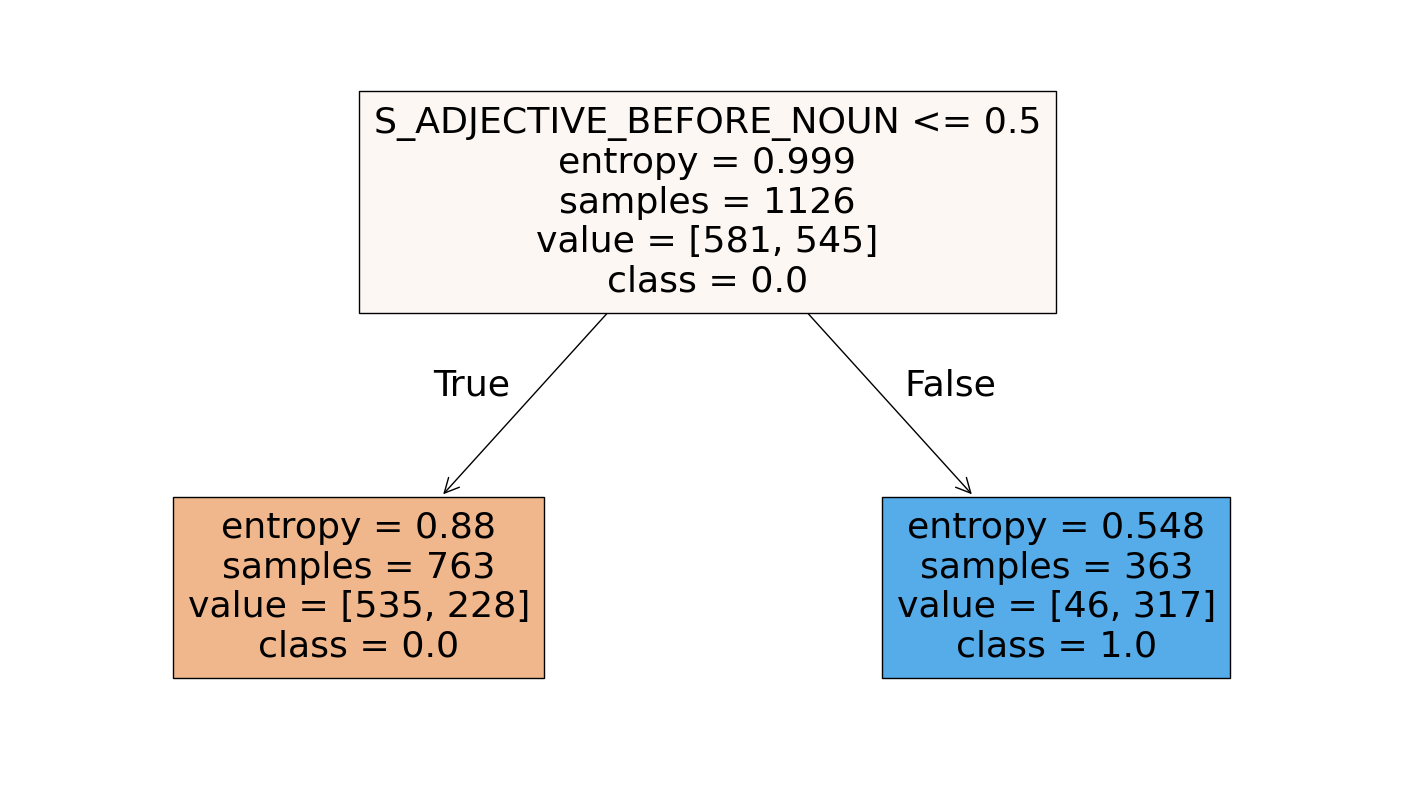

|--- S_ADJECTIVE_BEFORE_NOUN <= 0.50
|   |--- weights: [535.00, 228.00] class: 0.0
|--- S_ADJECTIVE_BEFORE_NOUN >  0.50
|   |--- weights: [46.00, 317.00] class: 1.0

Decision tree for predicting S_NUMERAL_BEFORE_NOUN
Results of the rule
total languages    1124.00
incomparable          0.00
correct             839.00
incorrect           285.00
tp                  305.00
fp                   57.00
tn                  534.00
fn                  228.00
accuracy              0.75
Name: S_NUMERAL_BEFORE_NOUN, dtype: float64
Accuracy of decision tree rule / Accuracy of Greenberg rule based classifier: 0.75 / 0.84
Related Greenberg rules
Rule 18: When the descriptive adjective precedes the noun, the demonstrative and the numeral likewise precede.


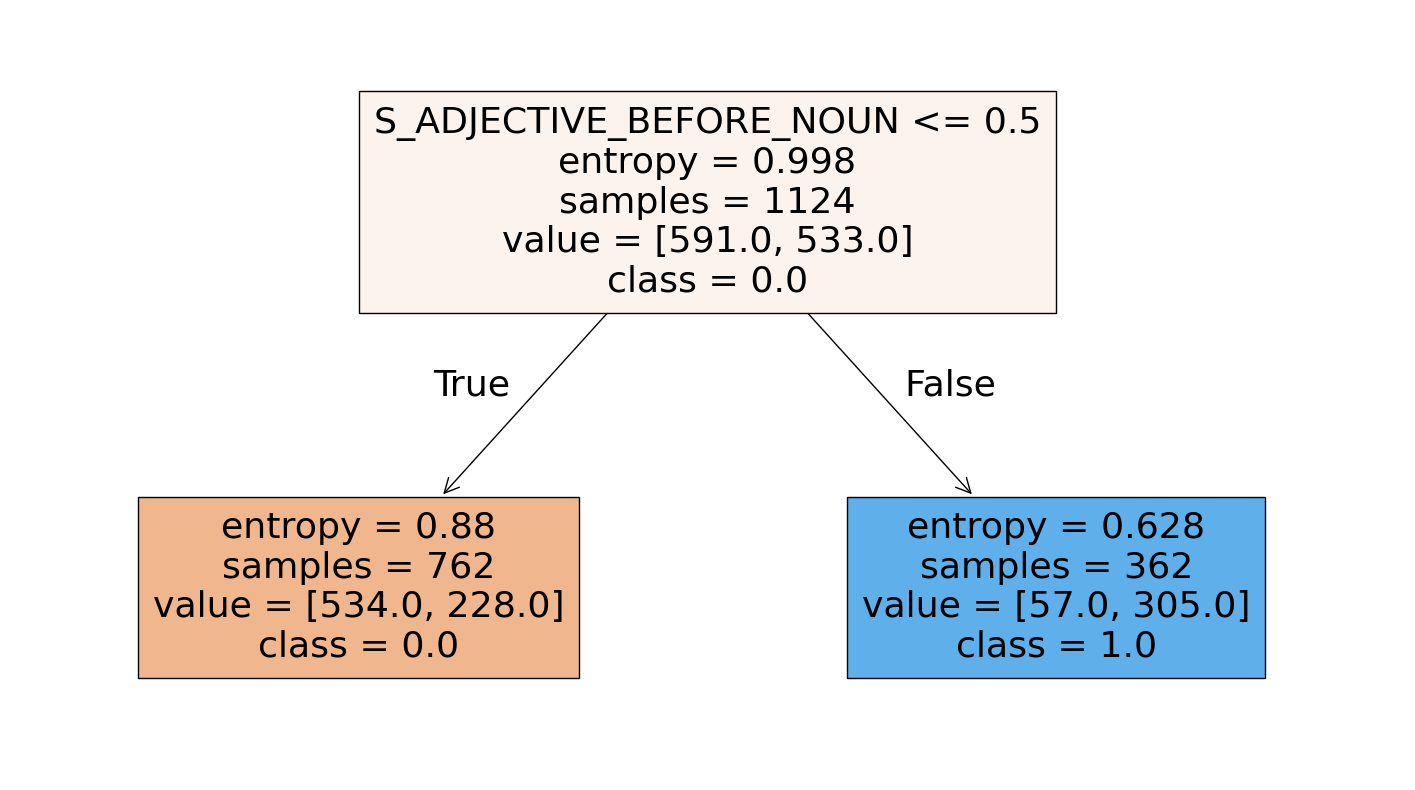

|--- S_ADJECTIVE_BEFORE_NOUN <= 0.50
|   |--- weights: [534.00, 228.00] class: 0.0
|--- S_ADJECTIVE_BEFORE_NOUN >  0.50
|   |--- weights: [57.00, 305.00] class: 1.0

Decision tree for predicting S_ADPOSITION_AFTER_NOUN
Results of the rule
total languages    1144.00
incomparable          0.00
correct             968.00
incorrect           176.00
tp                  531.00
fp                   96.00
tn                  437.00
fn                   80.00
accuracy              0.85
Name: S_ADPOSITION_AFTER_NOUN, dtype: float64
Accuracy of decision tree rule / Accuracy of Greenberg rule based classifier: 0.85 / 0.94
Related Greenberg rules
Rule 4: With overwhelmingly more than chance frequency, languages with normal SOV order are postpositional.
Rule  17: With overwhelmingly more than chance frequency, languages with dominant order SOV are postpositional.
Rule  22: If in a language the relative clause precedes the noun, the language is postpositional; if it follows, the language is prepositi

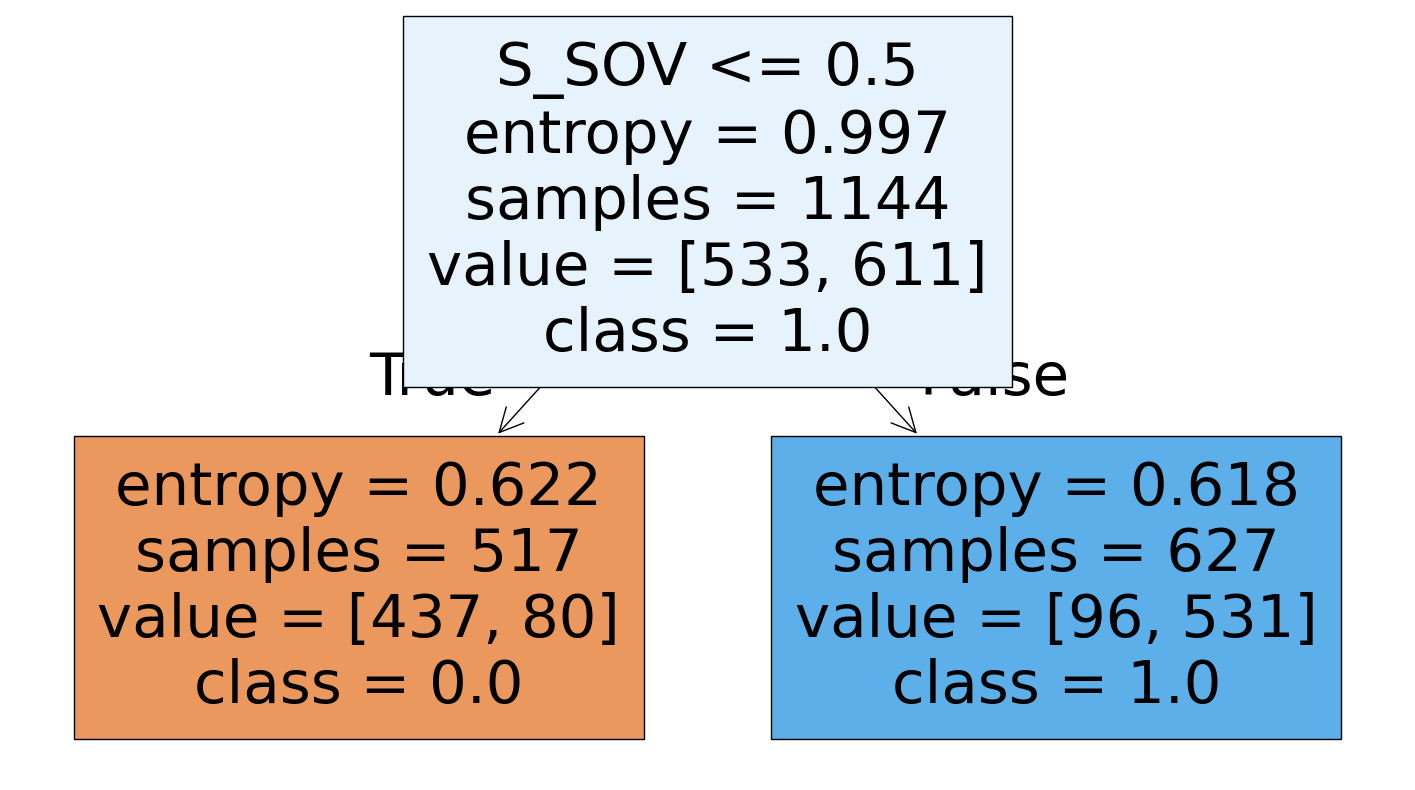

|--- S_SOV <= 0.50
|   |--- weights: [437.00, 80.00] class: 0.0
|--- S_SOV >  0.50
|   |--- weights: [96.00, 531.00] class: 1.0

Decision tree for predicting HAS_CASE_SYSTEM
Results of the rule
total languages    1560.00
incomparable          0.00
correct             994.00
incorrect           566.00
tp                  476.00
fp                  436.00
tn                  518.00
fn                  130.00
accuracy              0.64
Name: HAS_CASE_SYSTEM, dtype: float64
Accuracy of decision tree rule / Accuracy of Greenberg rule based classifier: 0.64 / 0.56
Related Greenberg rules
Rule 41: If in a language the verb follows both the nominal subject and nominal object as the dominant order, the language almost always has a case system.


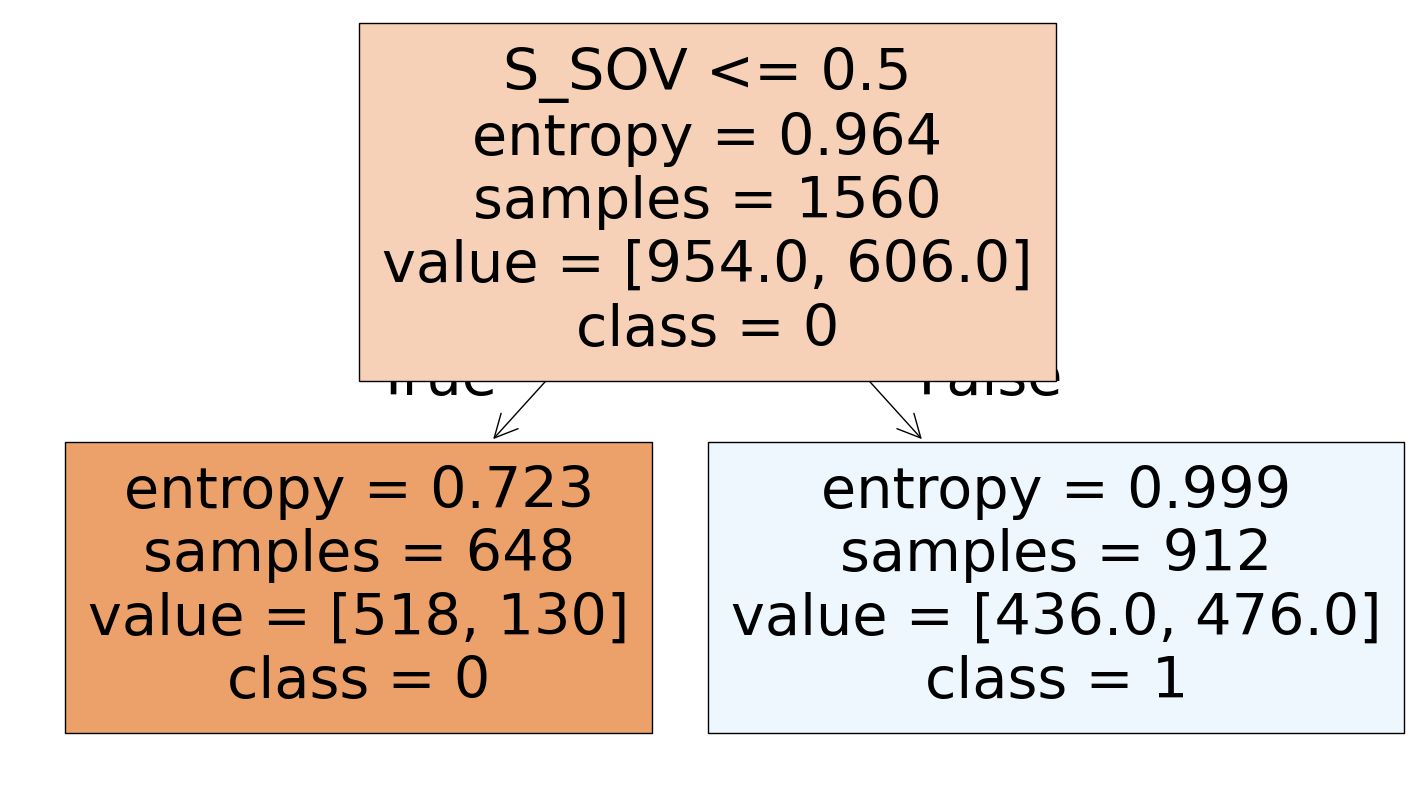

|--- S_SOV <= 0.50
|   |--- weights: [518.00, 130.00] class: 0
|--- S_SOV >  0.50
|   |--- weights: [436.00, 476.00] class: 1



In [47]:
plot_rules(results_decision_tree_comp_df_shallow, models_shallow, x_attributes_shallow)

## Conclusions

Note: For transparency every rule has been written down twice. Once where the rule is written only as what is in the WALS feature, e.g. if the feature, adjective precedes the noun is false, then it is not assumed that adjectives follows the noun. Once where the positions was considered as binary, e.g. if the feature, adjective precedes the noun is false, then it is assumed that adjectives follow the noun. <br>

The rules created by the decision tree were:

Rule: <br>
<b> If adjectives do not precede the noun, then demonstratives follow the noun. </b> <br>
Binary: <br>
<b> If adjectives follow the noun, then demonstratives follow the noun. </b> <br>
Accuracy: 66,9 % <br>
Correct/Incorrect: 511/252 <br>

Rule: <br>
<b> If adjectives precede the noun, then demonstratives do not follow the noun.</b> <br>
Binary: <br>
<b> If adjectives precede the noun, then demonstratives precede the noun.</b> <br>
Accuracy: 86.5 % <br>
Correct/Incorrect: 314 / 49 <br>

Rule: <br> 
<b> If adjectives do not follow the noun, then numerals do not follow the noun. </b> <br> 
Binary: <br> 
<b> If adjectives precede the noun, then numerals precede the noun. </b> <br>
Accuracy: 83.7 % <br>
Correct/Incorrect: 247 / 48 <br> 


Rule: <br>
<b> If adjectives follow the noun, then numerals follow the noun. </b> <br>
Accuracy: 73.2 % <br>
Correct/Incorrect: 607 / 222 <br> 

Rule: <br>
<b> If adpositions do not precede the noun, then possessors precede the noun. </b> <br>
Binary: <br>
<b> If adpositions follow the noun, then possessors precede the noun. </b> <br>
Accuracy: 96.7 % <br> 
Correct/Incorrect: 470 / 16 <br>


Rule: <br> 
<b> If adpositions precede the noun, then possessors do not precede the noun. </b> <br>
Binary: <br> 
<b> If adpositions precede the noun, then possessors follow the noun. </b> <br>
Accuracy: 61.2 % <br>
Correct/Incorrect: 447 / 283 <br>

Rule: <br>
<b> If the word order is not SOV, then adpositions precede the noun. </b> <br>
Accuracy: 89.0 % <br> 
Correct/Incorrect: 460 / 57 <br> 


Rule: <br> 
<b> If the word order is SOV, then adpositions do not precede the noun. </b> <br>
Binary:
<b>If the word order is SOV, then adpositions follow the noun. </b> <br>
Accuracy: 83.7 % <br>
Correct/Incorrect: 525 / 102 <br>

Rule: <br>
<b> If demonstratives do not precede the noun, then adjectives follow the noun. </b> <br>
Binary: <br>
<b> If demonstratives follow the noun, then adjectives follow the noun. </b> <br>
Accuracy: 94.6 % <br>
Correct/Incorrect: 506 / 29 <br>

Rule: <br>
<b> If demonstratives precede the noun, then adjectives follow the noun. </b> <br>
Accuracy: 57.3 % <br>
Correct/Incorrect: 446 / 333 <br>

Rule: <br>
<b>If demonstratives do not precede the noun, then adjectives do not preced the noun. </b> <br>
Binary: <br>
<b> If demonstratives follow the noun, then adjectives follow the noun. </b> <br>
Accuracy: 91.3 % <br> 
Correct/Incorrect: 489 / 46 <br>

Rule: <br>
<b> If demonstratives precede the noun, then adjectives precede the noun. </b> <br>
Accuracy: 53.6 % <br>
Correct/Incorrect: 418 / 361 <br>

Rule: <br>
<b> If adjectives do not precede the noun, then demonstratives do not precede the noun. </b> <br>
Binary: <br>
<b> If adjectives follow the noun, then demonstratives follow the noun. </b> <br>
Accuracy: 70.1 % <br>
Correct/Incorrect: 535 / 228 <br>

Rule: <br>
<b> If adjectives precede the noun, then demonstratives precede the noun. </b> <br>
Accuracy: 87.3 % <br> 
Correct/Incorrect: 317 / 46 <br>

Rule: <br> 
<b> If adjectives do not precede the noun, then numerals do not precede the noun. </b> <br>
Binary: <br>
<b> If adjectives follow the noun, then numerals follow the noun. </b> <br>
Accuracy: 70.1 % <br>
Correct/Incorrect: 534 / 228 <br>

Rule: <br>
<b> If adjectives precede the noun, then numerals precede the noun. </b> <br>
Accuracy: 84.2 % <br> 
Correct/Incorrect: 305 / 57 <br>

Rule: <br>
<b> If the word order is not SOV, then adpositions do not follow the noun. </b> <br>
Binary: <br>
<b> If the word order is not SOV, then adpositions precede the noun. </b> <br>
Accuracy: 84.5 % <br>
Correct/Incorrect: 437 / 80 <br>

Rule: <br>
<b> If the word order is SOV, then adpositions follow the noun. </b> <br>
Accuracy: 84.7 % <br>
Correct/Incorrect: 531 / 96 <br>

Rule: <br>
<b> If the word order is not SOV, then the language does not have a case system. </b> <br>
Accuracy: 79.9 % <br>
Correct/Incorrect: 518 / 130 <br>

Rule: <br>
<b> If the word order is SOV, then the language has a case system. </b> <br>
Accuracy: 52.2 % <br>
Correct/Incorrect: 476 / 436 <br>

# Creating rules using deeper decision trees

In [23]:
results_decision_tree_comp_deeper, models_deeper, x_attributes_deeper = train_tree(4)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [24]:
results_decision_tree_comp_df_deeper = pd.DataFrame.from_dict(
    {list(d.keys())[0]: list(d.values())[0] for d in results_decision_tree_comp_deeper},
    orient="index"
)
results_decision_tree_comp_df_deeper["accuracy"] = round((results_decision_tree_comp_df_deeper["tp"] + results_decision_tree_comp_df_deeper["tn"])/(results_decision_tree_comp_df_deeper["tp"] + results_decision_tree_comp_df_deeper["fp"] + results_decision_tree_comp_df_deeper["tn"] + results_decision_tree_comp_df_deeper["fn"]),2)
results_decision_tree_comp_df_deeper

,total languages,incomparable,correct,incorrect,tp,fp,tn,fn,accuracy
S_DEMONSTRATIVE_WORD_AFTER_NOUN,1126,0,886,240,439,119,447,121,0.79
S_NUMERAL_AFTER_NOUN,1124,0,879,245,579,169,300,76,0.78
S_POSSESSOR_BEFORE_NOUN,1216,0,1031,185,616,48,415,137,0.85
S_ADPOSITION_BEFORE_NOUN,1144,0,1023,121,510,69,513,52,0.89
S_ADJECTIVE_AFTER_NOUN,1314,0,1070,244,837,129,233,115,0.81
S_ADJECTIVE_BEFORE_NOUN,1314,0,1031,283,267,86,764,197,0.78
S_DEMONSTRATIVE_WORD_BEFORE_NOUN,1126,0,876,250,475,180,401,70,0.78
S_NUMERAL_BEFORE_NOUN,1124,0,873,251,336,54,537,197,0.78
S_ADPOSITION_AFTER_NOUN,1144,0,1000,144,519,52,481,92,0.87
HAS_CASE_SYSTEM,1560,0,1091,469,230,93,861,376,0.70


In [42]:
def plot_rules_deeper(results_decision_tree_comp_df, models, x_attributes, results_decision_tree_comp_df_shallow):
    for key in models:
        print(f"Decision tree for predicting {key}")
        plt.figure(figsize=(18, 10))
        tree.plot_tree(models[key], feature_names=x_attributes[key], class_names=models[key].classes_.astype(str), filled=True)
        print("Results of the rule")
        print(results_decision_tree_comp_df.loc[key])
        print(f"Accuracy of deeper decision tree rule / Accuracy of shallow decision tree rule / Accuracy of Greenberg rule based classifier: {results_decision_tree_comp_df.loc[key]['accuracy']} / {results_decision_tree_comp_df_shallow.loc[key]['accuracy']} / {results_rule_based_comp_df.loc[key]['accuracy']}")
        print("Related Greenberg rules")
        for value in str({results_rule_based_comp_df.loc[key]["Rule mapping"]}).split(","):
            string1 = value.strip("{}'")
            string2 = greenberg_rules[value.strip("{}'").strip(" ")]
            print(f"Rule {string1}: {string2}")
        plt.show()
        print(export_text(models[key], feature_names=x_attributes[key], show_weights=True))

Decision tree for predicting S_DEMONSTRATIVE_WORD_AFTER_NOUN
Results of the rule
total languages    1126.00
incomparable          0.00
correct             886.00
incorrect           240.00
tp                  439.00
fp                  119.00
tn                  447.00
fn                  121.00
accuracy              0.79
Name: S_DEMONSTRATIVE_WORD_AFTER_NOUN, dtype: float64
Accuracy of deeper decision tree rule / Accuracy of shallow decision tree rule / Accuracy of Greenberg rule based classifier: 0.79 / 0.73 / 0.66
Related Greenberg rules
Rule 19: When the descriptive adjective follows the noun, the demonstrative and the numeral likewise follow.


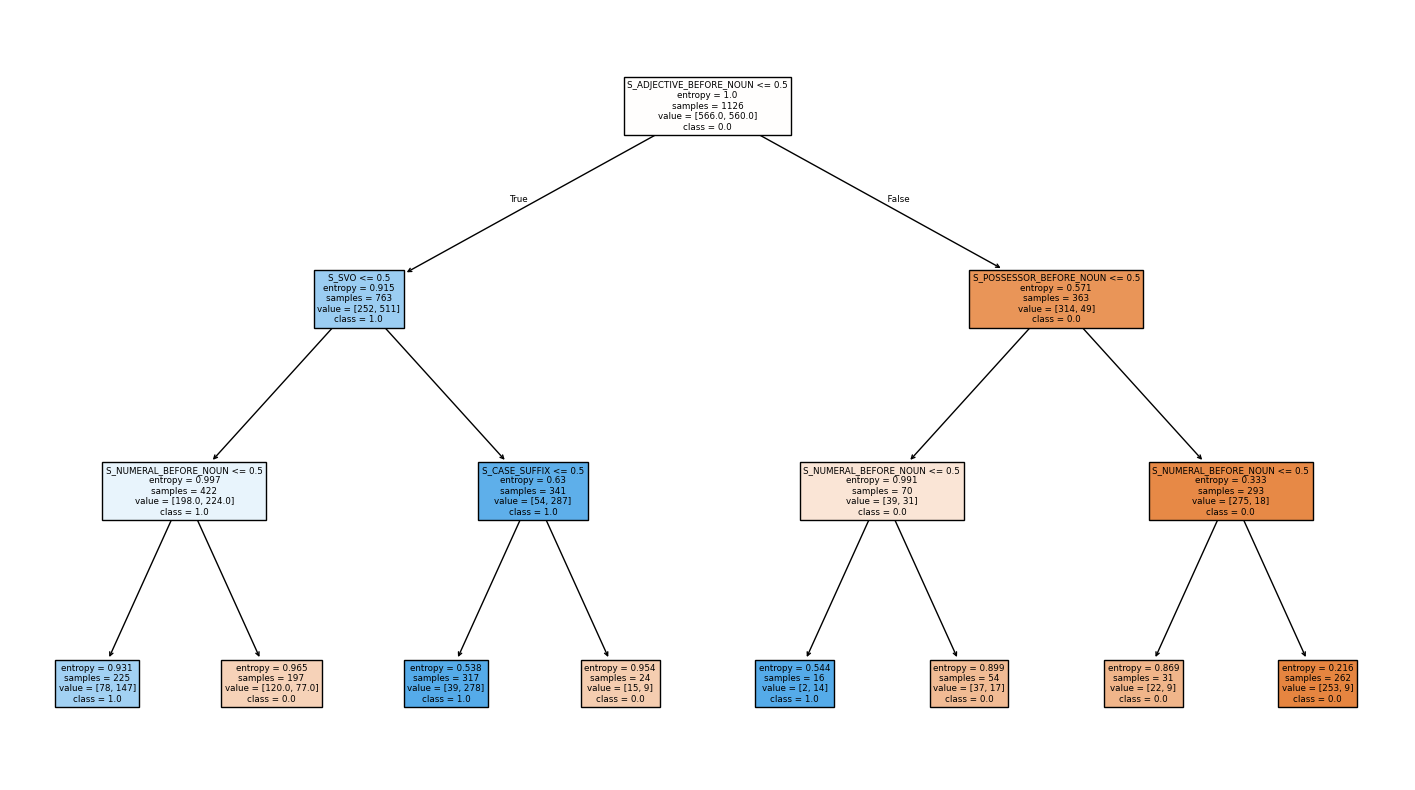

|--- S_ADJECTIVE_BEFORE_NOUN <= 0.50
|   |--- S_SVO <= 0.50
|   |   |--- S_NUMERAL_BEFORE_NOUN <= 0.50
|   |   |   |--- weights: [78.00, 147.00] class: 1.0
|   |   |--- S_NUMERAL_BEFORE_NOUN >  0.50
|   |   |   |--- weights: [120.00, 77.00] class: 0.0
|   |--- S_SVO >  0.50
|   |   |--- S_CASE_SUFFIX <= 0.50
|   |   |   |--- weights: [39.00, 278.00] class: 1.0
|   |   |--- S_CASE_SUFFIX >  0.50
|   |   |   |--- weights: [15.00, 9.00] class: 0.0
|--- S_ADJECTIVE_BEFORE_NOUN >  0.50
|   |--- S_POSSESSOR_BEFORE_NOUN <= 0.50
|   |   |--- S_NUMERAL_BEFORE_NOUN <= 0.50
|   |   |   |--- weights: [2.00, 14.00] class: 1.0
|   |   |--- S_NUMERAL_BEFORE_NOUN >  0.50
|   |   |   |--- weights: [37.00, 17.00] class: 0.0
|   |--- S_POSSESSOR_BEFORE_NOUN >  0.50
|   |   |--- S_NUMERAL_BEFORE_NOUN <= 0.50
|   |   |   |--- weights: [22.00, 9.00] class: 0.0
|   |   |--- S_NUMERAL_BEFORE_NOUN >  0.50
|   |   |   |--- weights: [253.00, 9.00] class: 0.0

Decision tree for predicting S_NUMERAL_AFTER_NOUN
Res

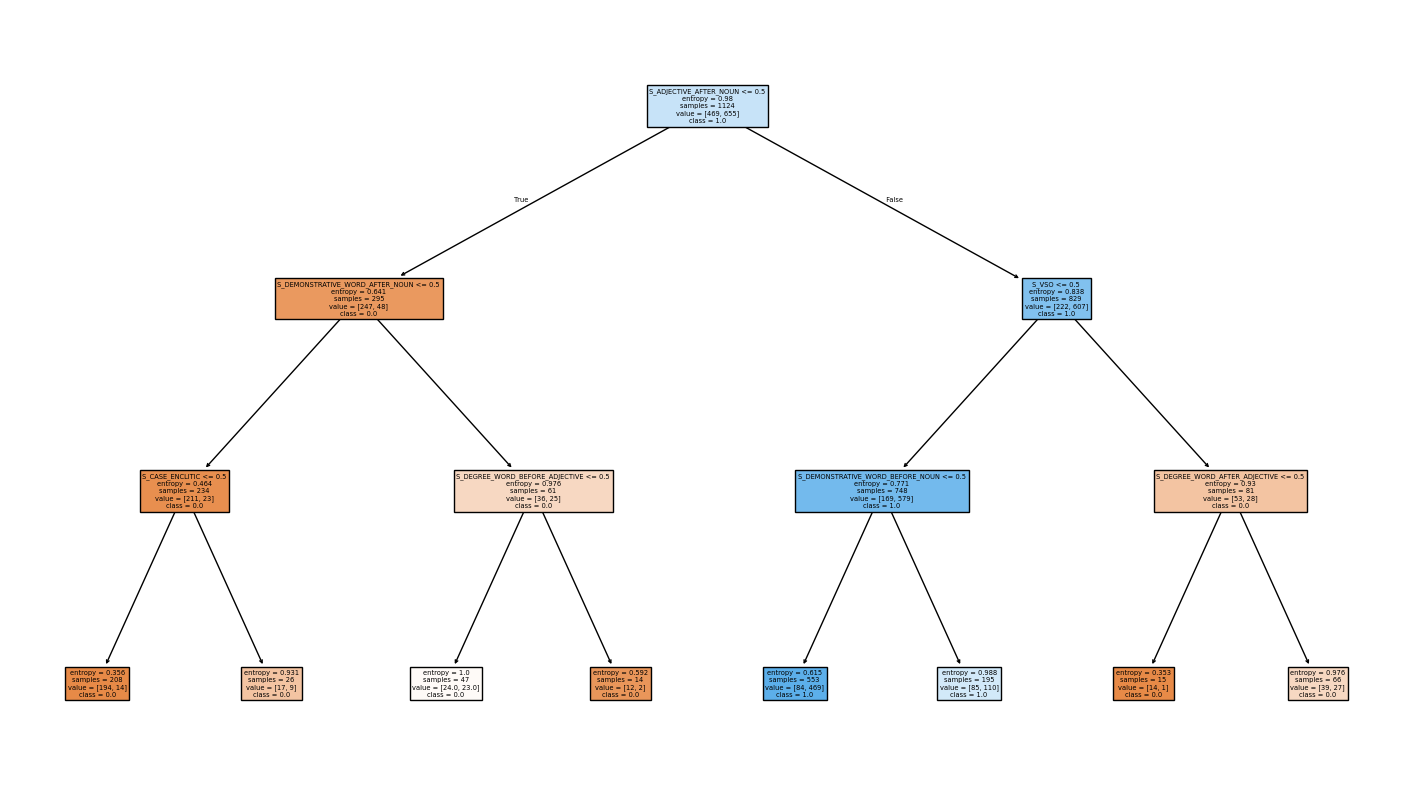

|--- S_ADJECTIVE_AFTER_NOUN <= 0.50
|   |--- S_DEMONSTRATIVE_WORD_AFTER_NOUN <= 0.50
|   |   |--- S_CASE_ENCLITIC <= 0.50
|   |   |   |--- weights: [194.00, 14.00] class: 0.0
|   |   |--- S_CASE_ENCLITIC >  0.50
|   |   |   |--- weights: [17.00, 9.00] class: 0.0
|   |--- S_DEMONSTRATIVE_WORD_AFTER_NOUN >  0.50
|   |   |--- S_DEGREE_WORD_BEFORE_ADJECTIVE <= 0.50
|   |   |   |--- weights: [24.00, 23.00] class: 0.0
|   |   |--- S_DEGREE_WORD_BEFORE_ADJECTIVE >  0.50
|   |   |   |--- weights: [12.00, 2.00] class: 0.0
|--- S_ADJECTIVE_AFTER_NOUN >  0.50
|   |--- S_VSO <= 0.50
|   |   |--- S_DEMONSTRATIVE_WORD_BEFORE_NOUN <= 0.50
|   |   |   |--- weights: [84.00, 469.00] class: 1.0
|   |   |--- S_DEMONSTRATIVE_WORD_BEFORE_NOUN >  0.50
|   |   |   |--- weights: [85.00, 110.00] class: 1.0
|   |--- S_VSO >  0.50
|   |   |--- S_DEGREE_WORD_AFTER_ADJECTIVE <= 0.50
|   |   |   |--- weights: [14.00, 1.00] class: 0.0
|   |   |--- S_DEGREE_WORD_AFTER_ADJECTIVE >  0.50
|   |   |   |--- weights: [39.00

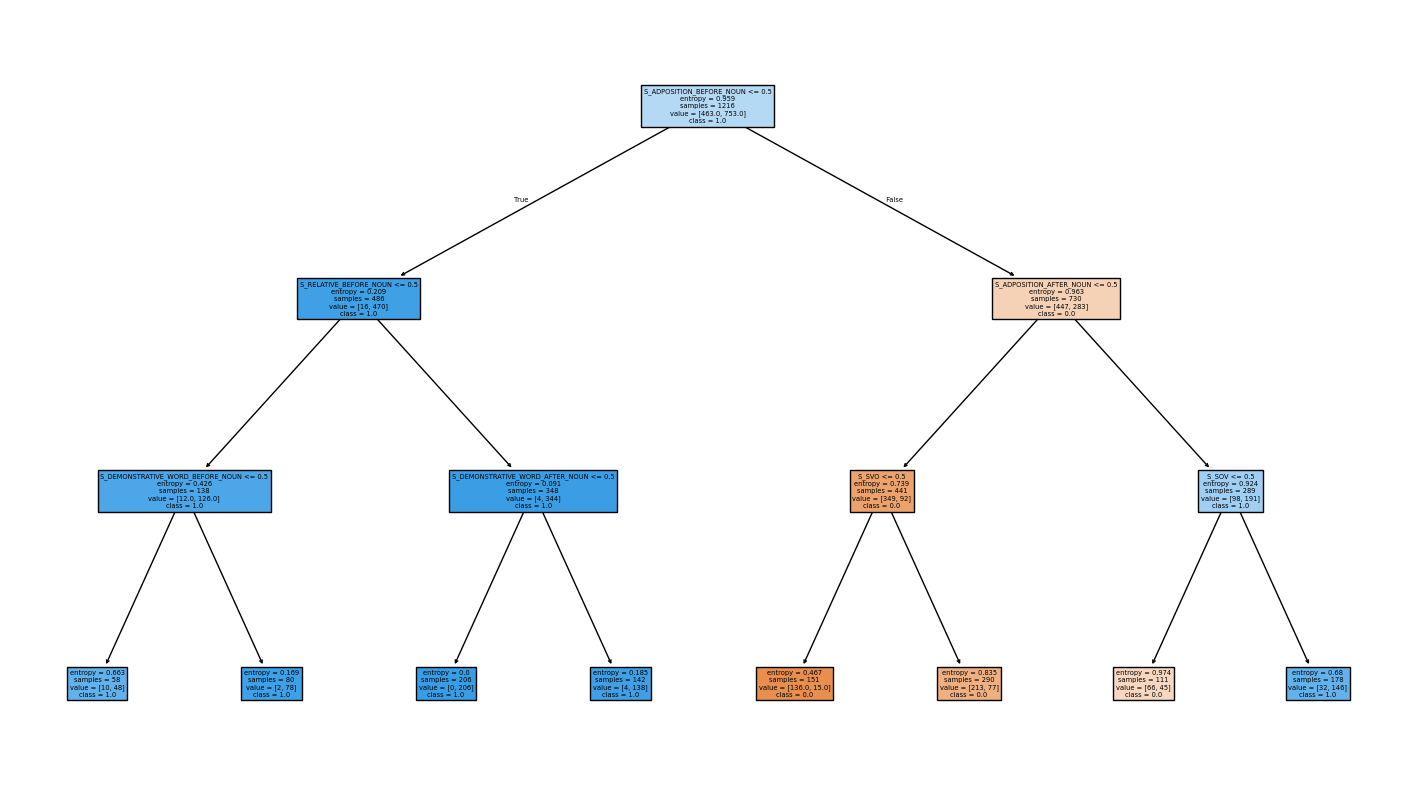

|--- S_ADPOSITION_BEFORE_NOUN <= 0.50
|   |--- S_RELATIVE_BEFORE_NOUN <= 0.50
|   |   |--- S_DEMONSTRATIVE_WORD_BEFORE_NOUN <= 0.50
|   |   |   |--- weights: [10.00, 48.00] class: 1.0
|   |   |--- S_DEMONSTRATIVE_WORD_BEFORE_NOUN >  0.50
|   |   |   |--- weights: [2.00, 78.00] class: 1.0
|   |--- S_RELATIVE_BEFORE_NOUN >  0.50
|   |   |--- S_DEMONSTRATIVE_WORD_AFTER_NOUN <= 0.50
|   |   |   |--- weights: [0.00, 206.00] class: 1.0
|   |   |--- S_DEMONSTRATIVE_WORD_AFTER_NOUN >  0.50
|   |   |   |--- weights: [4.00, 138.00] class: 1.0
|--- S_ADPOSITION_BEFORE_NOUN >  0.50
|   |--- S_ADPOSITION_AFTER_NOUN <= 0.50
|   |   |--- S_SVO <= 0.50
|   |   |   |--- weights: [136.00, 15.00] class: 0.0
|   |   |--- S_SVO >  0.50
|   |   |   |--- weights: [213.00, 77.00] class: 0.0
|   |--- S_ADPOSITION_AFTER_NOUN >  0.50
|   |   |--- S_SOV <= 0.50
|   |   |   |--- weights: [66.00, 45.00] class: 0.0
|   |   |--- S_SOV >  0.50
|   |   |   |--- weights: [32.00, 146.00] class: 1.0

Decision tree for pre

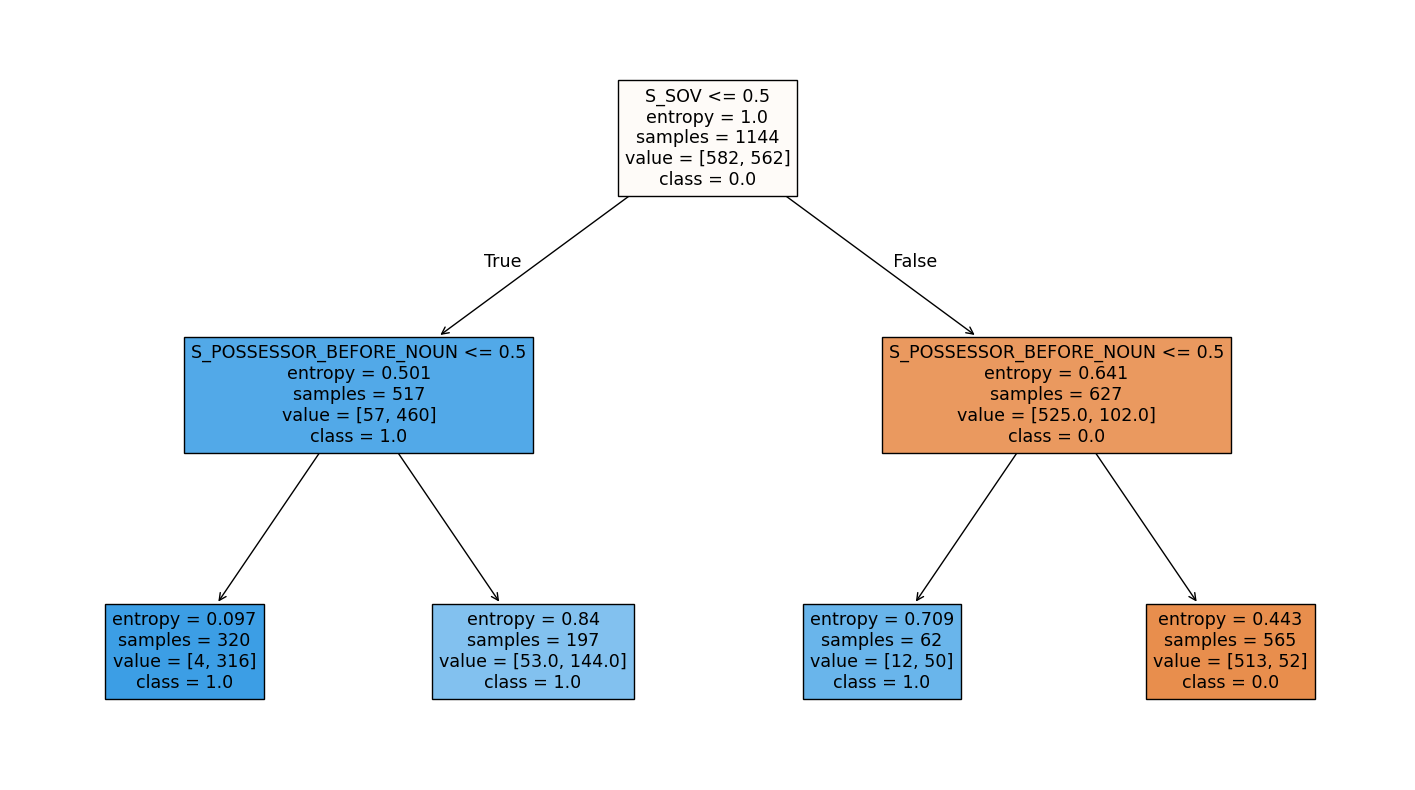

|--- S_SOV <= 0.50
|   |--- S_POSSESSOR_BEFORE_NOUN <= 0.50
|   |   |--- weights: [4.00, 316.00] class: 1.0
|   |--- S_POSSESSOR_BEFORE_NOUN >  0.50
|   |   |--- weights: [53.00, 144.00] class: 1.0
|--- S_SOV >  0.50
|   |--- S_POSSESSOR_BEFORE_NOUN <= 0.50
|   |   |--- weights: [12.00, 50.00] class: 1.0
|   |--- S_POSSESSOR_BEFORE_NOUN >  0.50
|   |   |--- weights: [513.00, 52.00] class: 0.0

Decision tree for predicting S_ADJECTIVE_AFTER_NOUN
Results of the rule
total languages    1314.00
incomparable          0.00
correct            1070.00
incorrect           244.00
tp                  837.00
fp                  129.00
tn                  233.00
fn                  115.00
accuracy              0.81
Name: S_ADJECTIVE_AFTER_NOUN, dtype: float64
Accuracy of deeper decision tree rule / Accuracy of shallow decision tree rule / Accuracy of Greenberg rule based classifier: 0.81 / 0.72 / 0.65
Related Greenberg rules
Rule 5: If a language has dominant SOV order and the genitive follows the 

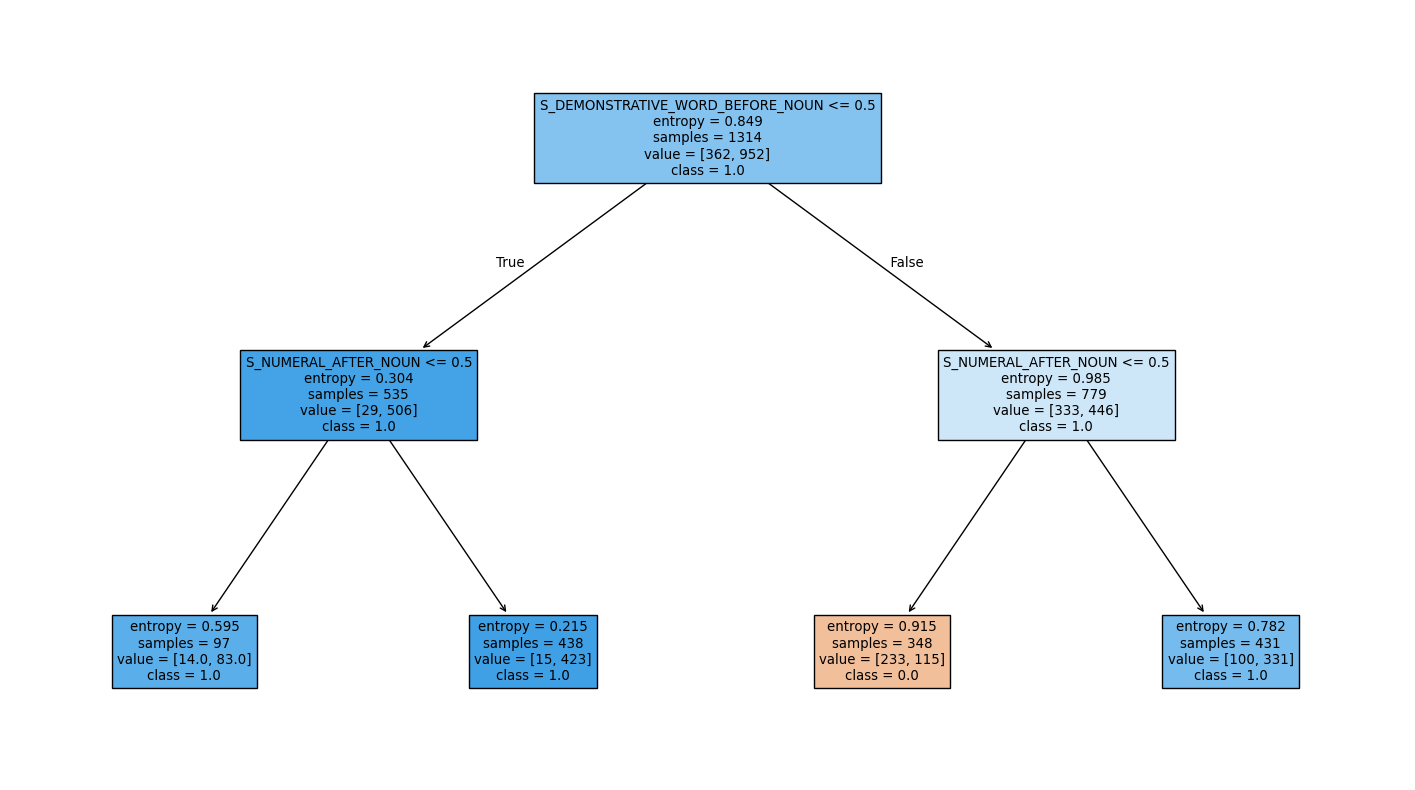

|--- S_DEMONSTRATIVE_WORD_BEFORE_NOUN <= 0.50
|   |--- S_NUMERAL_AFTER_NOUN <= 0.50
|   |   |--- weights: [14.00, 83.00] class: 1.0
|   |--- S_NUMERAL_AFTER_NOUN >  0.50
|   |   |--- weights: [15.00, 423.00] class: 1.0
|--- S_DEMONSTRATIVE_WORD_BEFORE_NOUN >  0.50
|   |--- S_NUMERAL_AFTER_NOUN <= 0.50
|   |   |--- weights: [233.00, 115.00] class: 0.0
|   |--- S_NUMERAL_AFTER_NOUN >  0.50
|   |   |--- weights: [100.00, 331.00] class: 1.0

Decision tree for predicting S_ADJECTIVE_BEFORE_NOUN
Results of the rule
total languages    1314.00
incomparable          0.00
correct            1031.00
incorrect           283.00
tp                  267.00
fp                   86.00
tn                  764.00
fn                  197.00
accuracy              0.78
Name: S_ADJECTIVE_BEFORE_NOUN, dtype: float64
Accuracy of deeper decision tree rule / Accuracy of shallow decision tree rule / Accuracy of Greenberg rule based classifier: 0.78 / 0.69 / 0.25
Related Greenberg rules
Rule 23: If in a language t

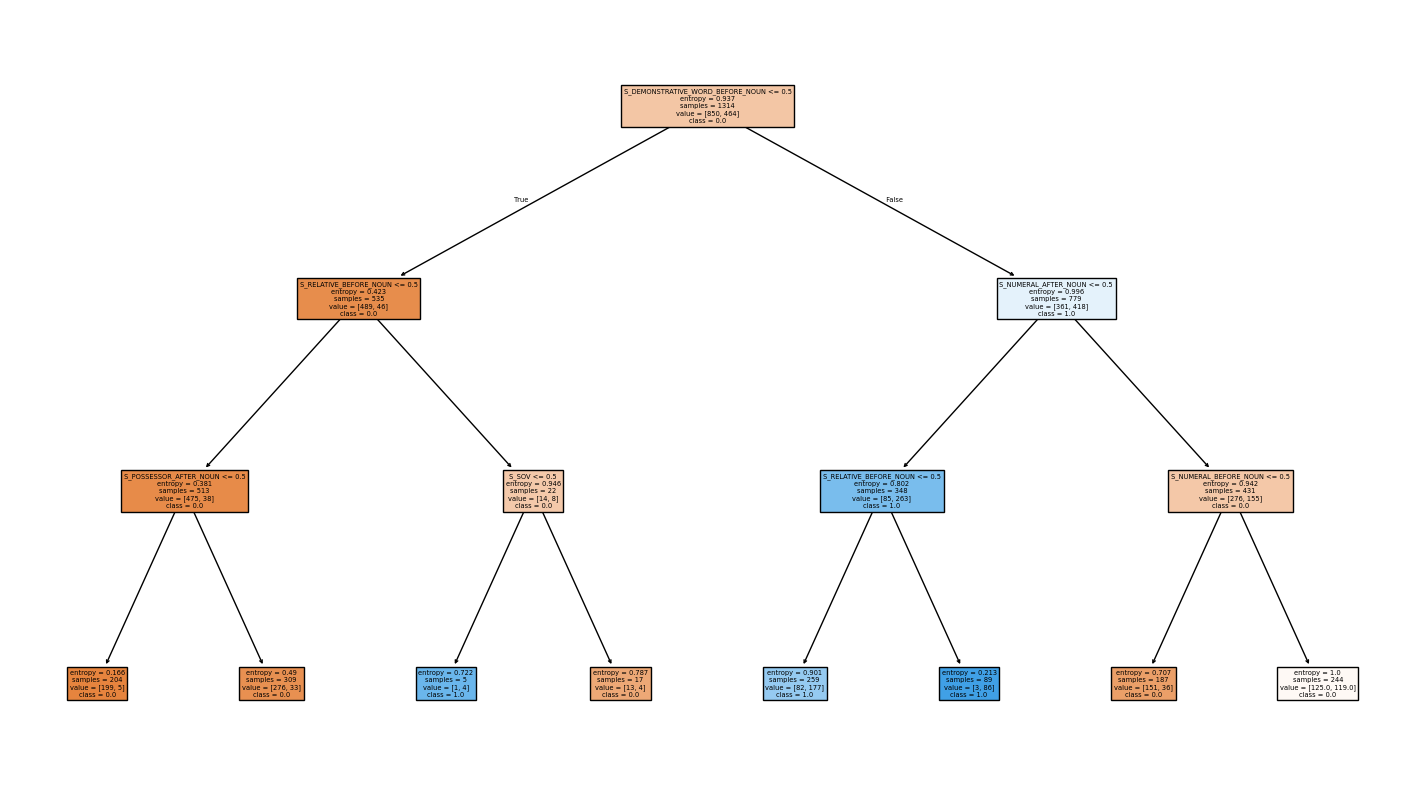

|--- S_DEMONSTRATIVE_WORD_BEFORE_NOUN <= 0.50
|   |--- S_RELATIVE_BEFORE_NOUN <= 0.50
|   |   |--- S_POSSESSOR_AFTER_NOUN <= 0.50
|   |   |   |--- weights: [199.00, 5.00] class: 0.0
|   |   |--- S_POSSESSOR_AFTER_NOUN >  0.50
|   |   |   |--- weights: [276.00, 33.00] class: 0.0
|   |--- S_RELATIVE_BEFORE_NOUN >  0.50
|   |   |--- S_SOV <= 0.50
|   |   |   |--- weights: [1.00, 4.00] class: 1.0
|   |   |--- S_SOV >  0.50
|   |   |   |--- weights: [13.00, 4.00] class: 0.0
|--- S_DEMONSTRATIVE_WORD_BEFORE_NOUN >  0.50
|   |--- S_NUMERAL_AFTER_NOUN <= 0.50
|   |   |--- S_RELATIVE_BEFORE_NOUN <= 0.50
|   |   |   |--- weights: [82.00, 177.00] class: 1.0
|   |   |--- S_RELATIVE_BEFORE_NOUN >  0.50
|   |   |   |--- weights: [3.00, 86.00] class: 1.0
|   |--- S_NUMERAL_AFTER_NOUN >  0.50
|   |   |--- S_NUMERAL_BEFORE_NOUN <= 0.50
|   |   |   |--- weights: [151.00, 36.00] class: 0.0
|   |   |--- S_NUMERAL_BEFORE_NOUN >  0.50
|   |   |   |--- weights: [125.00, 119.00] class: 0.0

Decision tree for 

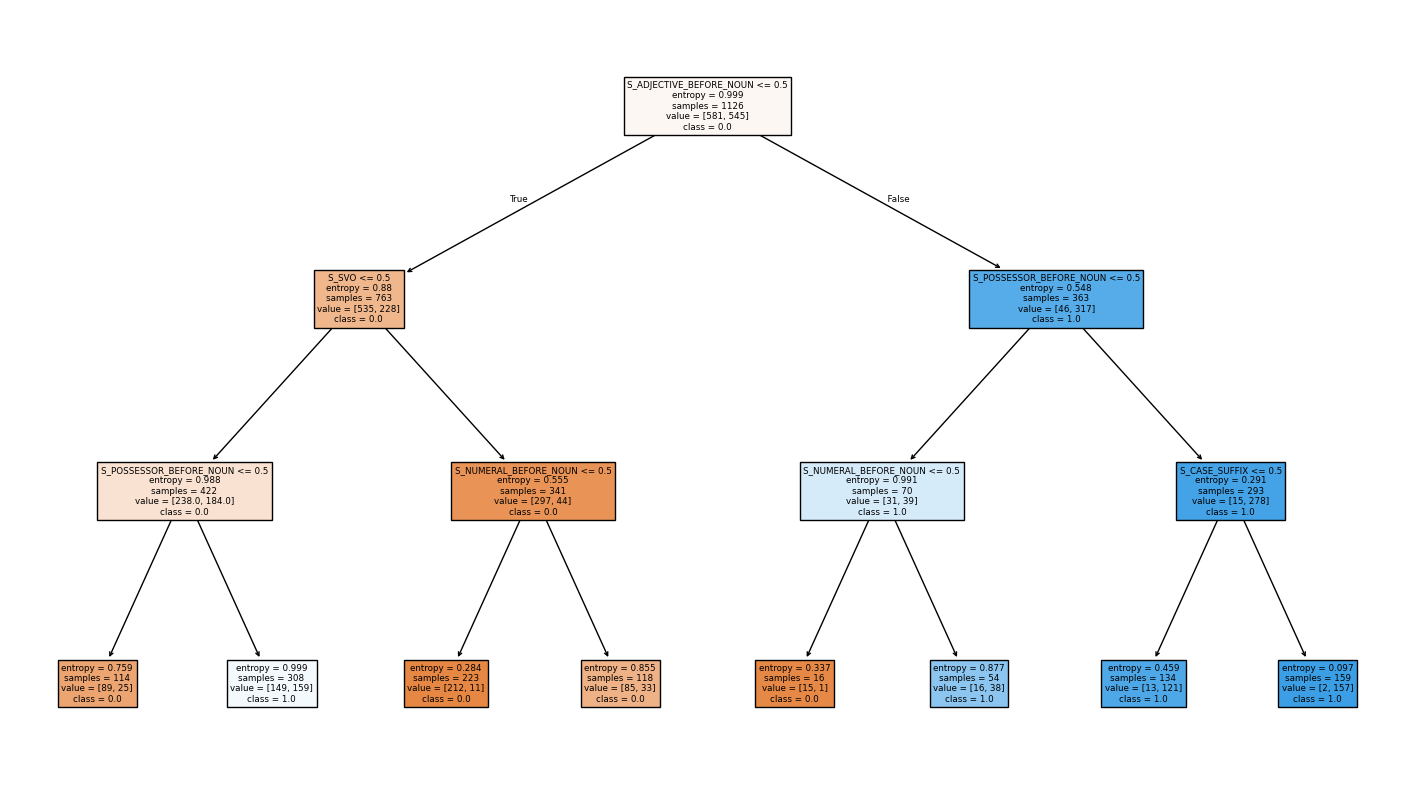

|--- S_ADJECTIVE_BEFORE_NOUN <= 0.50
|   |--- S_SVO <= 0.50
|   |   |--- S_POSSESSOR_BEFORE_NOUN <= 0.50
|   |   |   |--- weights: [89.00, 25.00] class: 0.0
|   |   |--- S_POSSESSOR_BEFORE_NOUN >  0.50
|   |   |   |--- weights: [149.00, 159.00] class: 1.0
|   |--- S_SVO >  0.50
|   |   |--- S_NUMERAL_BEFORE_NOUN <= 0.50
|   |   |   |--- weights: [212.00, 11.00] class: 0.0
|   |   |--- S_NUMERAL_BEFORE_NOUN >  0.50
|   |   |   |--- weights: [85.00, 33.00] class: 0.0
|--- S_ADJECTIVE_BEFORE_NOUN >  0.50
|   |--- S_POSSESSOR_BEFORE_NOUN <= 0.50
|   |   |--- S_NUMERAL_BEFORE_NOUN <= 0.50
|   |   |   |--- weights: [15.00, 1.00] class: 0.0
|   |   |--- S_NUMERAL_BEFORE_NOUN >  0.50
|   |   |   |--- weights: [16.00, 38.00] class: 1.0
|   |--- S_POSSESSOR_BEFORE_NOUN >  0.50
|   |   |--- S_CASE_SUFFIX <= 0.50
|   |   |   |--- weights: [13.00, 121.00] class: 1.0
|   |   |--- S_CASE_SUFFIX >  0.50
|   |   |   |--- weights: [2.00, 157.00] class: 1.0

Decision tree for predicting S_NUMERAL_BEFORE_

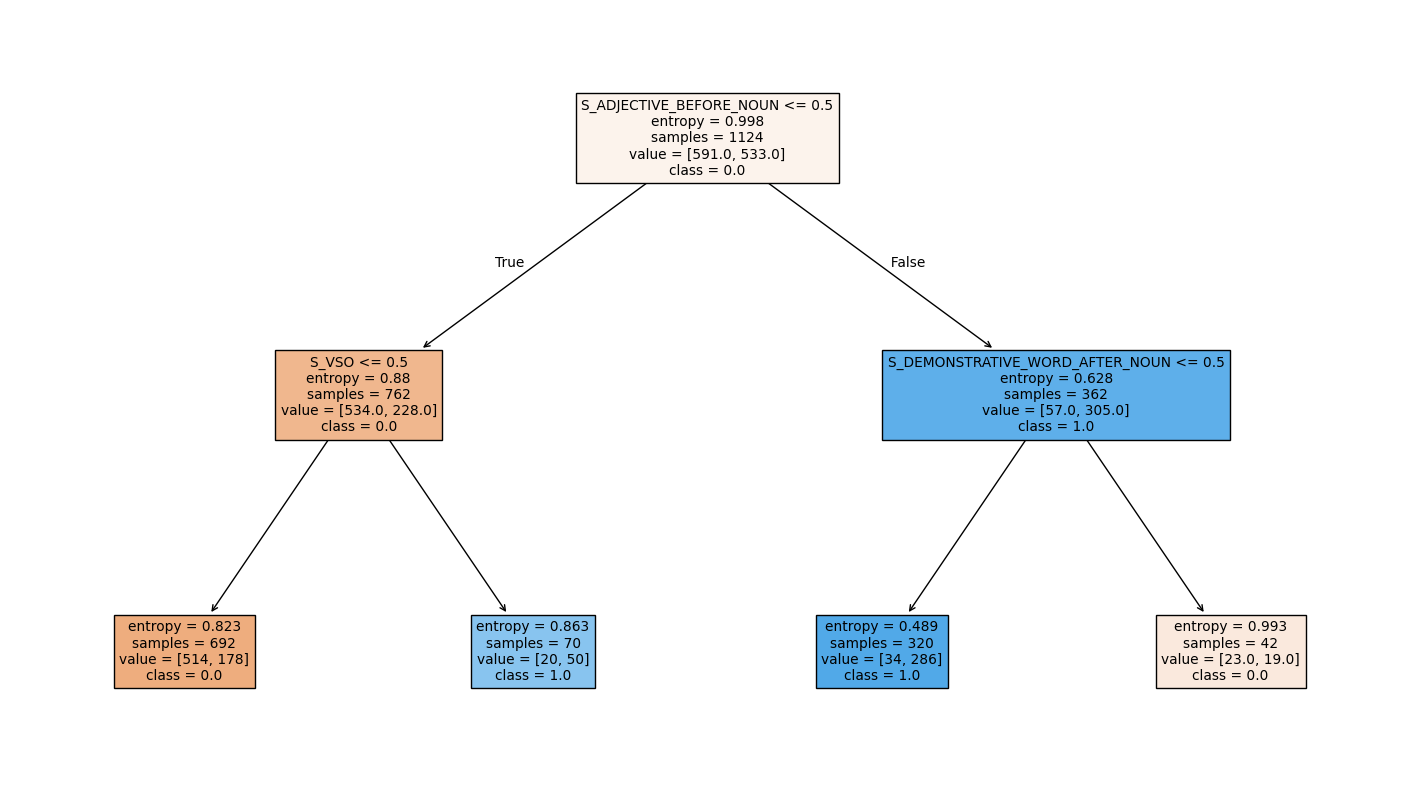

|--- S_ADJECTIVE_BEFORE_NOUN <= 0.50
|   |--- S_VSO <= 0.50
|   |   |--- weights: [514.00, 178.00] class: 0.0
|   |--- S_VSO >  0.50
|   |   |--- weights: [20.00, 50.00] class: 1.0
|--- S_ADJECTIVE_BEFORE_NOUN >  0.50
|   |--- S_DEMONSTRATIVE_WORD_AFTER_NOUN <= 0.50
|   |   |--- weights: [34.00, 286.00] class: 1.0
|   |--- S_DEMONSTRATIVE_WORD_AFTER_NOUN >  0.50
|   |   |--- weights: [23.00, 19.00] class: 0.0

Decision tree for predicting S_ADPOSITION_AFTER_NOUN
Results of the rule
total languages    1144.00
incomparable          0.00
correct            1000.00
incorrect           144.00
tp                  519.00
fp                   52.00
tn                  481.00
fn                   92.00
accuracy              0.87
Name: S_ADPOSITION_AFTER_NOUN, dtype: float64
Accuracy of deeper decision tree rule / Accuracy of shallow decision tree rule / Accuracy of Greenberg rule based classifier: 0.87 / 0.85 / 0.94
Related Greenberg rules
Rule 4: With overwhelmingly more than chance frequency,

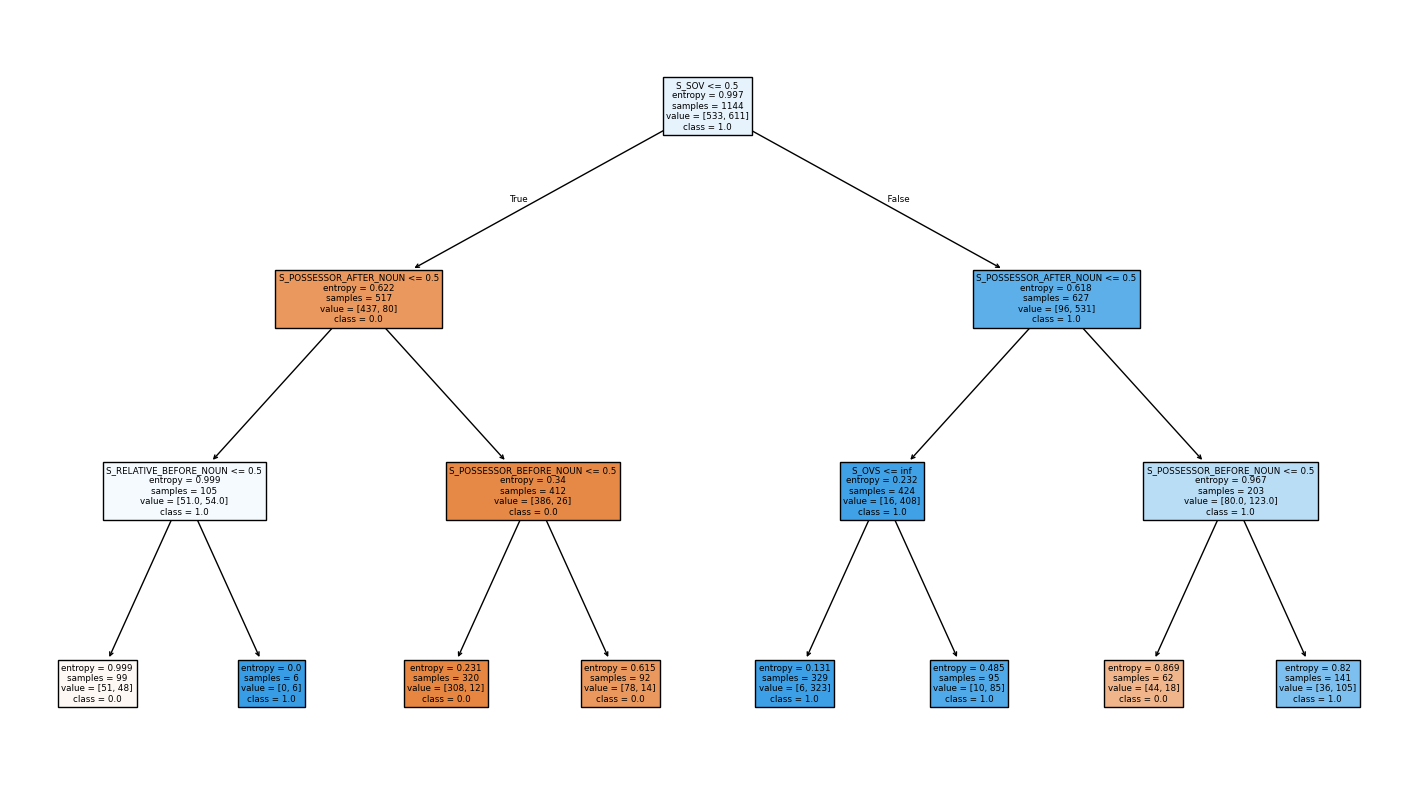

|--- S_SOV <= 0.50
|   |--- S_POSSESSOR_AFTER_NOUN <= 0.50
|   |   |--- S_RELATIVE_BEFORE_NOUN <= 0.50
|   |   |   |--- weights: [51.00, 48.00] class: 0.0
|   |   |--- S_RELATIVE_BEFORE_NOUN >  0.50
|   |   |   |--- weights: [0.00, 6.00] class: 1.0
|   |--- S_POSSESSOR_AFTER_NOUN >  0.50
|   |   |--- S_POSSESSOR_BEFORE_NOUN <= 0.50
|   |   |   |--- weights: [308.00, 12.00] class: 0.0
|   |   |--- S_POSSESSOR_BEFORE_NOUN >  0.50
|   |   |   |--- weights: [78.00, 14.00] class: 0.0
|--- S_SOV >  0.50
|   |--- S_POSSESSOR_AFTER_NOUN <= 0.50
|   |   |--- S_OVS <= inf
|   |   |   |--- weights: [6.00, 323.00] class: 1.0
|   |   |--- S_OVS >  inf
|   |   |   |--- weights: [10.00, 85.00] class: 1.0
|   |--- S_POSSESSOR_AFTER_NOUN >  0.50
|   |   |--- S_POSSESSOR_BEFORE_NOUN <= 0.50
|   |   |   |--- weights: [44.00, 18.00] class: 0.0
|   |   |--- S_POSSESSOR_BEFORE_NOUN >  0.50
|   |   |   |--- weights: [36.00, 105.00] class: 1.0

Decision tree for predicting HAS_CASE_SYSTEM
Results of the rule


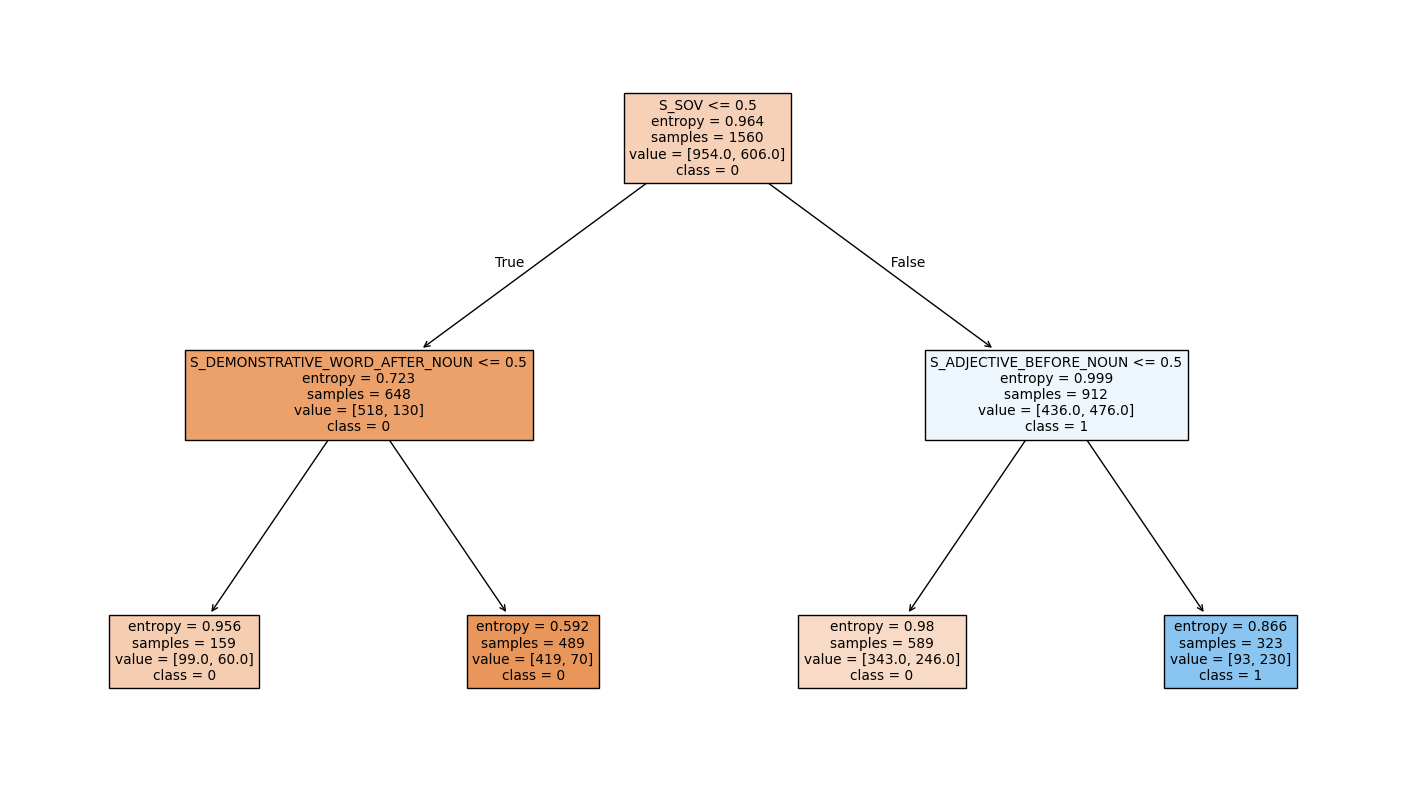

|--- S_SOV <= 0.50
|   |--- S_DEMONSTRATIVE_WORD_AFTER_NOUN <= 0.50
|   |   |--- weights: [99.00, 60.00] class: 0
|   |--- S_DEMONSTRATIVE_WORD_AFTER_NOUN >  0.50
|   |   |--- weights: [419.00, 70.00] class: 0
|--- S_SOV >  0.50
|   |--- S_ADJECTIVE_BEFORE_NOUN <= 0.50
|   |   |--- weights: [343.00, 246.00] class: 0
|   |--- S_ADJECTIVE_BEFORE_NOUN >  0.50
|   |   |--- weights: [93.00, 230.00] class: 1



In [43]:
plot_rules_deeper(results_decision_tree_comp_df_deeper, models_deeper, x_attributes_deeper, results_decision_tree_comp_df_shallow)

## Conclusions

Some of the rules created from the decision tree outperforms the Greenberg rules in terms of accuracy and some do not. Below are rules for predicting features of a languages that offer a significant accuracy improvment over the once previously defined by Greenberg, as well as the rules that could be derived from the shallow trees. <br>

Note: As in the shallow decision tree, every rule has been written down twice. Once where the rule is written only as what is in the WALS feature, e.g. if the feature, adjective precedes the noun is false, then it is not assumed that adjectives follows the noun. Once where the positions was considered as binary, e.g. if the feature, adjective precedes the noun is false, then it is assumed that adjectives follow the noun. <br>

There are cases where the position can be both before and after, therefore this binary assumption is not completely correct. For making comprehension of the rules simpler and to keep them in the same format as the original Greenberg rule, these exceptions are ignored in the second version of the rules marked as binary. <br>


<h3> Predicting if possessors will precede the noun </h3> 
WALS feature predicted: S_POSSESSOR_BEFORE_NOUN <br>
Related Greenberg rules: <br>
&nbsp &nbsp Rule 20: When any or all of the modifiers precede the noun, the genitive almost always precedes. <br>
&nbsp &nbsp Rule  21: When any or all of the modifiers follow the noun, the genitive almost always follows. <br>

Accuracy of Greenberg rule based classifier: 0.62 <br>


Rule: <br>
<b>If adpositions, relatives and demonstratives do not precede the noun, <br>
then possessor precedes the noun </b> <br>

Binary rule: <br>
<b> If adpositions relatives and demonstratives follows the noun, <br>
then possessors precedes the noun </b> <br>

Accuracy: 82,7% <br>
Correct/Incorrect: 48/10 <br>


Rule: <br>
<b> If adpositions and relatives do not precede the noun, and demonstratives precedes the noun, <br>
then possessor precedes the noun </b> <br>
Binary rule: <br>
<b> If adpositions and relatives follows the noun, and demonstratives precedes the noun, <br>
then possessors precedes the noun </b> <br>

Accuracy: 97,5 <br>
Correct/Incorrect: 78/2 <br>

Rule: <br>
<b> If adpositions  do not precede the noun and demonstratives do no follow the noun but relatives precedes the noun, <br>
then possessors precedes the noun </b> <br>
Binary rule: <br>
<b> If adpositions and demonstratives follows the noun and relatives precedes the noun, <br>
then possessors precedes the noun </b> <br>

Accuracy: 100 % <br>
Correct/Incorrect: 206/0 <br>

Rule: <br>
<b> If adpositions do not precede the noun and relatives precedes the noun and demonstratives follow the noun, <br>
then possessors precedes the noun </b> <br>
Binary rule: <br>
<b> If adpositions and demonstratives follows the noun and relatives precedes the noun, <br>
then possessors precedes the noun </b> <br>


Accuracy: 97,2 % <br>
Correct/Incorrect: 138/4 <br>


Rule: <br>
<b> If adpositions precedes the noun and adpositions do not follow the noun, and the word order is not SVO, <br>
then possessor do not precede the noun </b> <br>
Binary: <br>
<b> If adpositions precedes the noun and the word order is not SVO, <br>
then possessors follows the noun </b> <br>

Accuracy:  90,1 % <br>
Correct/Incorrect: 136/15 <br>


Rule: <br>
<b> If adpositions preceds the noun and do not to follow the noun and the word order is SVO, <br>
then possesors do not precede the noun. </b> <br>
Binary: <br>
<b> If adpositions precedes the noun and the word order is SVO, <br>
then possessors follows the noun </b> <br>

Accuracy:  73,4 % <br>
Correct/Incorrect: 213/77 <br>


Rule: <br>
<b> If adpositions both precede and follow the noun and the word order is not SOV, <br>
then possessors do not precede the noun </b> <br>
Binary: <br>
<b> If adpositions both precede and follow the noun and the word order is not SOV, <br> 
then possessors follows the noun </b> <br>

Accuracy:  59,5 % <br>
Correct/Incorrect: 66/45 <br>


Rule: <br>
<b> If adpositions both precede and follow the noun and the word order is SOV, <br>
then possessors precedes the noun </b> <br>

Accuracy:  82% <br>
Correct/Incorrect: 146/32 <br>




<h3> Predicting if adjectives will precede the noun </h3>
WALS feature predicted: S_ADJECTIVE_BEFORE_NOUN <br>
Related Greenberg rule: <br>
&nbsp &nbsp Rule 23: If in a language the verb precedes the object, the adjective likewise precedes the noun. <br>

Accuracy of Greenberg rule based classifier: 0.25 <br>

Rule: <br>
<b> If demonstratives and relatives do not precede the noun and possessors do not follow the noun, <br>
then adjectives do not precede the noun </b> <br>
Binary: <br>
<b> If demonstratives and possessors precedes the noun, and relatives follows the noun, <br>
then adjectives follows the noun </b> <br>
Accuracy: 97.5% <br>
Correct/Incorrect: 199/5 <br>

Rule: <br>
<b> If demonstratives and relatives do not precede the noun and possessors follows the noun, <br>
then adjectives do not precede the noun </b> <br>
Binary: <br>
<b> If demonstratives and relatives follows the noun and possessors follows the noun, <br>
then adjectives follows the noun </b> <br>
Accuracy: 89% <br>
Correct/Incorrect: 276/33 <br>

Rule: <br>
<b> If demonstratives do not precede the noun and relatives precedes the noun and the word order is not SOV, <br>
then adjectives precedes the noun </b> <br>
Binary: <br>
<b> If demonstratives follows the noun and relatives precedes the noun and the word order is not SOV, <br>
then adjectives precedes the noun </b> <br>
Accuracy: 80% <br>
Correct/Incorrect: 4/1 <br>

Rule: <br>
<b> If demonstratives do not precede the noun and relatives precedes the noun and the word order is SOV, <br>
then adjectives do not precede the noun. </b> <br> 
Binary: <br>
<b> If demonstratives follows the noun and relatives precedes the noun and the word order is SOV, <br>
then adjectives follows the noun </b> <br>
Accuracy: 76% <br>
Correct/Incorrect: 13/4 <br>

Rule: <br>
<b> If demonstratives precedes the noun and numerals do not follow the noun and relatives do not precede the noun, <br>
then adjectives precedes the noun </b> <br>
Binary: <br>
<b> If demonstratives and numerals precedes the noun and relatives follows the noun, <br>
then adjectives precedes the noun </b> <br>
Accuracy: 68% <br>
Correct/Incorrect: 177/82 <br>


Rule: <br>
<b> If demonstratives and relatives precede the noun and numerals do not follow the noun, <br>
then adjectives precedes the noun </b> </br>
Binary: <br>
<b> If demonstratives, numerals and relatives precedes the noun, <br>
then adjectives precedes the noun </b> <br>
Accuracy: 96.6% <br>
Correct/Incorrect: 86/3 <br>


Rule: <br>
<b>
If demonstratives precede the noun and numerals follow the noun and numerals do not precede the noun, <br>
then adjectives do not precede the noun </b> <br>
Binary: <br>
<b>
If demonstratives precede the noun and numerals follow the noun, <br>
then adjectives follow the noun </b> <br>
Accuracy: 80.7% <br>
Correct/Incorrect: 151/36 <br>


Rule: <br>
<b>
If demonstratives precede the noun and numerals both follow and precede the noun, <br>
then adjectives do not precede the noun </b> <br>
Binary: <br>
<b>If demonstratives precede the noun and numerals both follow and precede the noun, <br>
then adjectives follow the noun </b> <br>
Accuracy: 51.1% <br>
Correct/Incorrect: 125/119 <br>



<h3> Predicting if a language has a case system </h3>
WALS feature predicted: HAS_CASE_SYSTEM, which is combination of the  <br>
Related Greenberg rule: <br>
&nbsp &nbsp Rule 41: If in a language the verb follows both the nominal subject and nominal object as the dominant order, the language almost always has a case system. <br>

Accuracy of Greenberg rule based classifier: 0.56<br>

Rule: <br>
<b>
If the word order is not SOV and demonstratives do not follow the noun, <br>
then the language does not have a case system
</b> <br>
Accuracy: 62.2% <br>
Correct/Incorrect: 99/60 <br>

Rule: <br>
<b>
If the word order is not SOV and demonstrative words follow the noun, <br>
then the language does not have a case system
</b> <br>
Accuracy: 85.7% <br>
Correct/Incorrect: 419/70 <br>

Rule: <br>
<b>
If the word order is SOV and adjectives do not precede the noun, <br>
then the language does not have a case system
</b> <br>
Accuracy: 58.2% <br>
Correct/Incorrect: 343/246 <br>

Rule: <br>
<b>
If the word order is SOV and adjectives precede the noun, <br>
then the language has a case system
</b> <br>
Accuracy: 71.2% <br>
Correct/Incorrect: 230/93 <br>

